### K562 overexpression example

This notebook prepares a dataset from a tech-dev paper with a gazillion Perturb-seq experiments applied to mostly K562 ([Replogle et al 2020](https://www.nature.com/articles/s41587-020-0470-y)). We'll focus on just the CRISPRa multiplexing experiment, which does overexpression. 

Here we tidy the dataset and carry out a simple exploration in scanpy.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

import anndata
import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/gary/cahan_rotation/perturbation_data")

# Universal
geneAnnotationPath = "setup/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath = "setup/tfList.csv"                                 # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "setup/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 
cellcycleGenePath = "setup/regev_lab_cell_cycle_genes.txt"

# Replogle1 Specific
dataset_name = "replogle"
perturbEffectTFOnlyPath = "setup/replogle1TFOnly.csv"                         # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/replogle1FullTranscriptome.csv"   # a path to store temp file

### How many TF's are perturbed?

In [2]:
human_tfs = pd.read_csv(humanTFPath)
EpiList   = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
replogle_perturbations = pd.read_csv(f"not_ready/{dataset_name}/perturbed_genes.csv")
replogle_perturbations.drop_duplicates(inplace = True)
replogle_perturbations["is_tf"] = replogle_perturbations["gene"].isin(human_tfs["HGNC symbol"]) # | replogle_perturbations["gene"].isin(EpiList["HGNC_symbol"]) 
display(replogle_perturbations.groupby("experiment").count()) #total
display(replogle_perturbations.groupby("experiment").sum()) #tf only
replogle_perturbations.query("experiment=='CRISPRa multiplex'")["gene"].unique() #which TF's

gene  is_tf
experiment                    
CRISPRa multiplex    63     63
CRISPRi multiplex   104    104
IPSC                 19     19
Interaction          41     42
UPR validation       30     30

is_tf
experiment              
CRISPRa multiplex     33
CRISPRi multiplex      9
IPSC                   5
Interaction            2
UPR validation         0

array(['CDKN1A', 'CDKN1B', 'CEBPB', 'CERKL', 'COL2A1', 'EOMES', 'ETS2',
       'FOXC1', 'HHEX', 'HIC2', 'HOXD13', 'IGDCC3', 'IRF1', 'KLF1',
       'LHX4', 'MAP2K3', 'MAP2K6', 'MAPK1', 'MEIS2', 'NEUROD1', 'NPM1',
       'PRTG', 'PTPN1', 'SET', 'SPI1', 'TIPARP', 'TLE3', 'TTC6', 'ZNF296',
       'AIRE', 'ASCL1', 'ATF4', 'ATF5', 'BACH2', 'CCDC51', 'COX5A',
       'CREB1', 'DDIT3', 'DDIT4', 'EIF2S1', 'FOXP3', 'GATA3', 'HIF1A',
       'HSF1', 'HSPA9', 'HSPD1', 'MTOR', 'NEUROG2', 'NRF1', 'PISD',
       'PPARGC1A', 'RANBP1', 'RORA', 'RPL30', 'RPS18', 'SREBF1', 'TBX21',
       'TFAP4', 'TIMM50', 'TMA7', 'UPF1', 'ZNF236', 'ZNF574'],
      dtype=object)

### Load expression data & set up cell metadata

In [3]:
if not os.path.exists(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip"):
    expression_quantified = sc.read_10x_mtx(f"not_ready/{dataset_name}/GSM4367986_exp8/")
    expression_quantified.write_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip", compression="gzip")
else:
    expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip")

In [4]:
sc.pp.calculate_qc_metrics(expression_quantified, inplace = True)
cell_metadata = pd.read_csv(f"not_ready/{dataset_name}/GSM4367986_exp8/cell_identities.csv.gz")
cell_metadata.index = cell_metadata["cell_barcode"]
cell_metadata["target_symbol"] = ingestion.convert_ens_to_symbol(
    cell_metadata["target"], 
    gtf=geneAnnotationPath, 
    strip_version = True)
cell_metadata["target_is_tf"] = cell_metadata["target_symbol"].isin(human_tfs["HGNC symbol"]).astype("int")
expression_quantified.obs = pd.merge(expression_quantified.obs,
                                     cell_metadata, 
                                     how = "left", 
                                     left_index = True, 
                                     right_index = True)

expression_quantified.obs["has_guide_annotations"] = pd.notnull(expression_quantified.obs["coverage"]).astype("int")
expression_quantified.obs["good_coverage"] = expression_quantified.obs["good_coverage"].astype("str")
expression_quantified.raw = expression_quantified.copy()

In [5]:
expression_quantified = expression_quantified[~expression_quantified.obs.target_symbol.isna(), :]

### How many cells do we have for each target?

target_symbol  n_cells  is_tf
0           CEBPB      212   True
1            LHX4      238   True
2           PTPN1      284  False
3          CDKN1B      303  False
4           TBX21      315   True
..            ...      ...    ...
59           TTC6     1513  False
60          RPL30     1712  False
61           MTOR     1735  False
62         MAP2K3     1861  False
63  Non-Targeting     5126  False

[64 rows x 3 columns]

Text(0.5, 1.0, 'CRISPRa in K562')

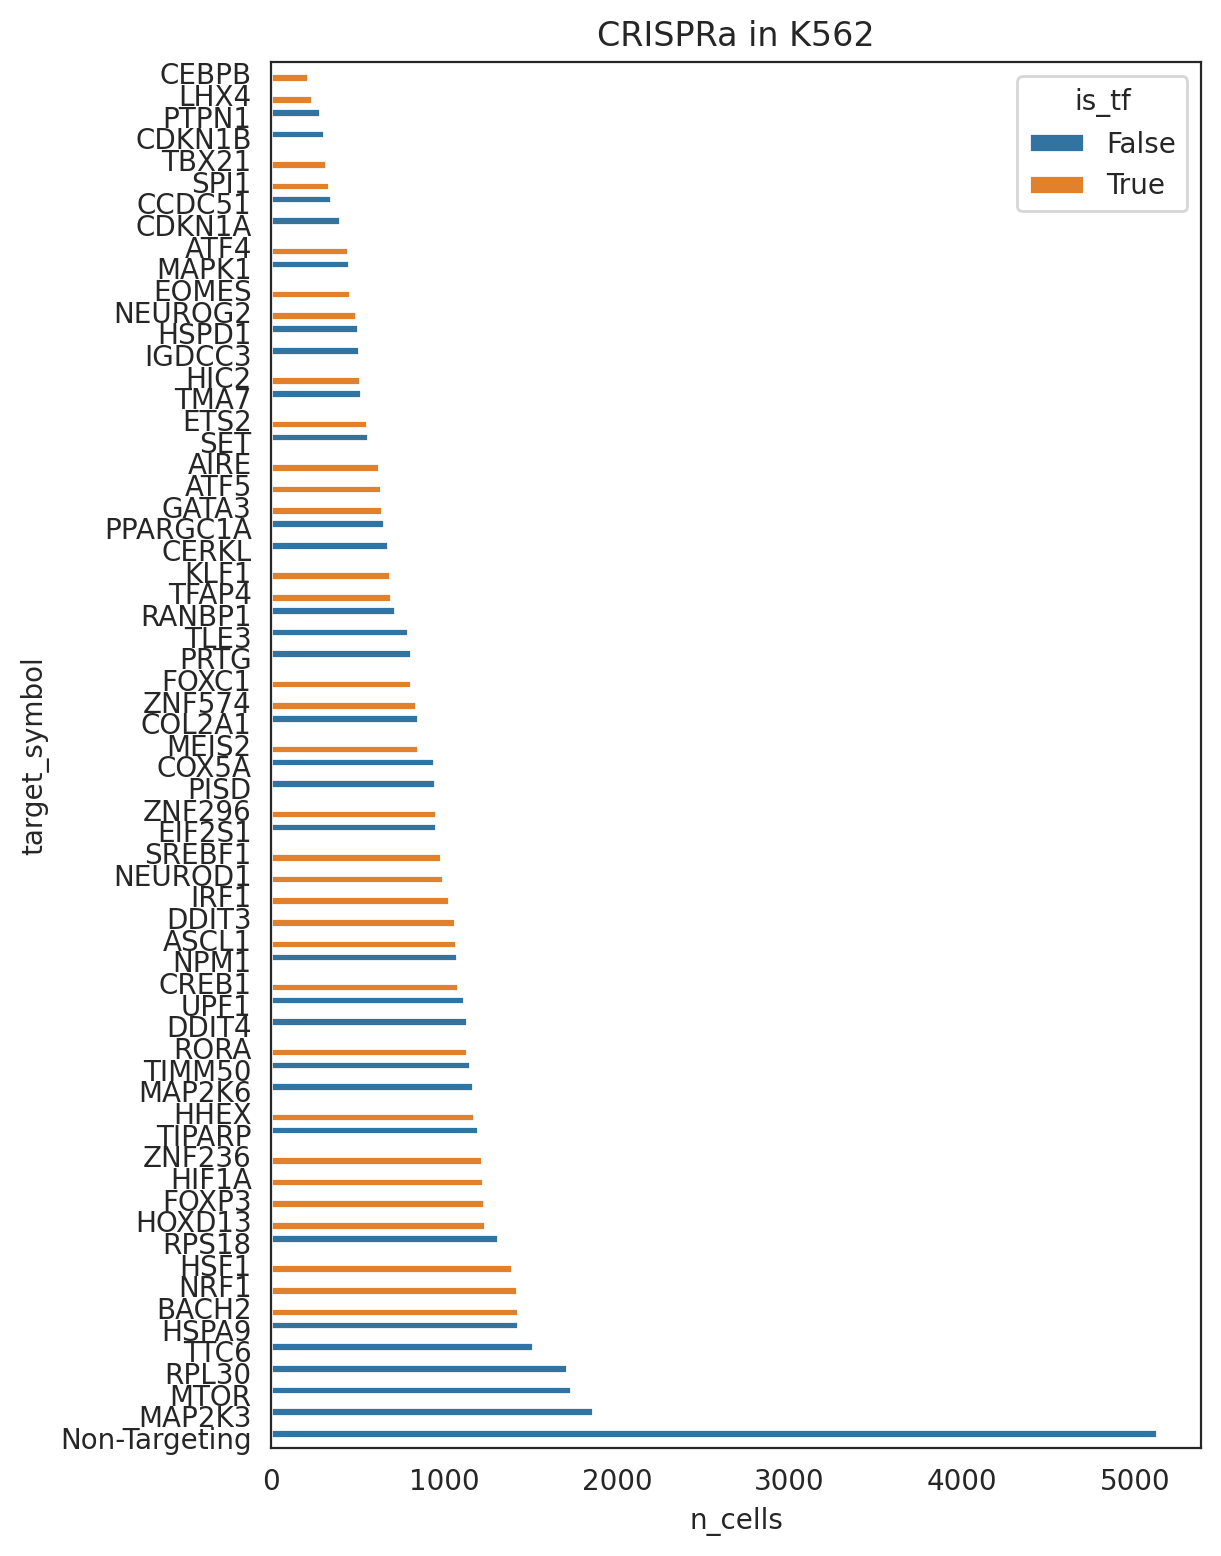

In [6]:
n_cells_per_target = expression_quantified.obs.groupby("target_symbol")[["cell_barcode"]].count().sort_values("cell_barcode")
n_cells_per_target.columns = ["n_cells"]
n_cells_per_target["is_tf"] = n_cells_per_target.index.isin(human_tfs["HGNC symbol"])
n_cells_per_target.reset_index(inplace = True)
display(n_cells_per_target)
plt.rcParams['figure.figsize'] = [6, 9]
sns.barplot(data = n_cells_per_target, x = "n_cells", y = "target_symbol", hue = "is_tf").set_title("CRISPRa in K562")

### Convert ensembl gene id's to gene symbol

In [7]:
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf=geneAnnotationPath, 
)
display(expression_quantified.var.head())
display(expression_quantified.var_names[0:5])

gene_ids    feature_types  n_cells_by_counts  \
RP11-34P13.3  ENSG00000243485  Gene Expression                 14   
FAM138A       ENSG00000237613  Gene Expression                  0   
OR4F5         ENSG00000186092  Gene Expression                  0   
RP11-34P13.7  ENSG00000238009  Gene Expression                343   
RP11-34P13.8  ENSG00000239945  Gene Expression                 55   

              mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
RP11-34P13.3     0.000127           0.000127              99.987326   
FAM138A          0.000000           0.000000             100.000000   
OR4F5            0.000000           0.000000             100.000000   
RP11-34P13.7     0.003105           0.003100              99.689486   
RP11-34P13.8     0.000498           0.000498              99.950209   

              total_counts  log1p_total_counts  
RP11-34P13.3          14.0            2.708050  
FAM138A                0.0            0.000000  
OR4F5                  0.0            0.000000  
RP11-34P13.7         343.0            5.840641  
RP11-34P13.8          55.0            4.025352

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8'], dtype='object')

### Fill `perturbation` & `Is_control`

In [8]:
controls = ["Non-Targeting"]
expression_quantified.obs["perturbation"]     = expression_quantified.obs['target_symbol']
expression_quantified.obs["is_control"]       = expression_quantified.obs['target_symbol'].isin(controls)
expression_quantified.obs["is_control_int"]   = expression_quantified.obs['target_symbol'].isin(controls).astype(int)

In [9]:
expression_quantified

AnnData object with n_obs × n_vars = 60725 × 33694
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cell_barcode', 'guide_identity', 'num_guides', 'gene', 'best_gamma', 'correction', 'distance', 'gamma_A', 'gamma_B', 'gene_type', 'protospacer_A', 'protospacer_B', 'rank_A', 'rank_B', 'sgID_A', 'sgID_B', 'type', 'target', 'umi_A', 'umi_B', 'read_count', 'UMI_count', 'coverage', 'good_coverage', 'number_of_cells', 'gemgroup', 'target_symbol', 'target_is_tf', 'has_guide_annotations', 'perturbation', 'is_control', 'is_control_int'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### single-cell standard filters

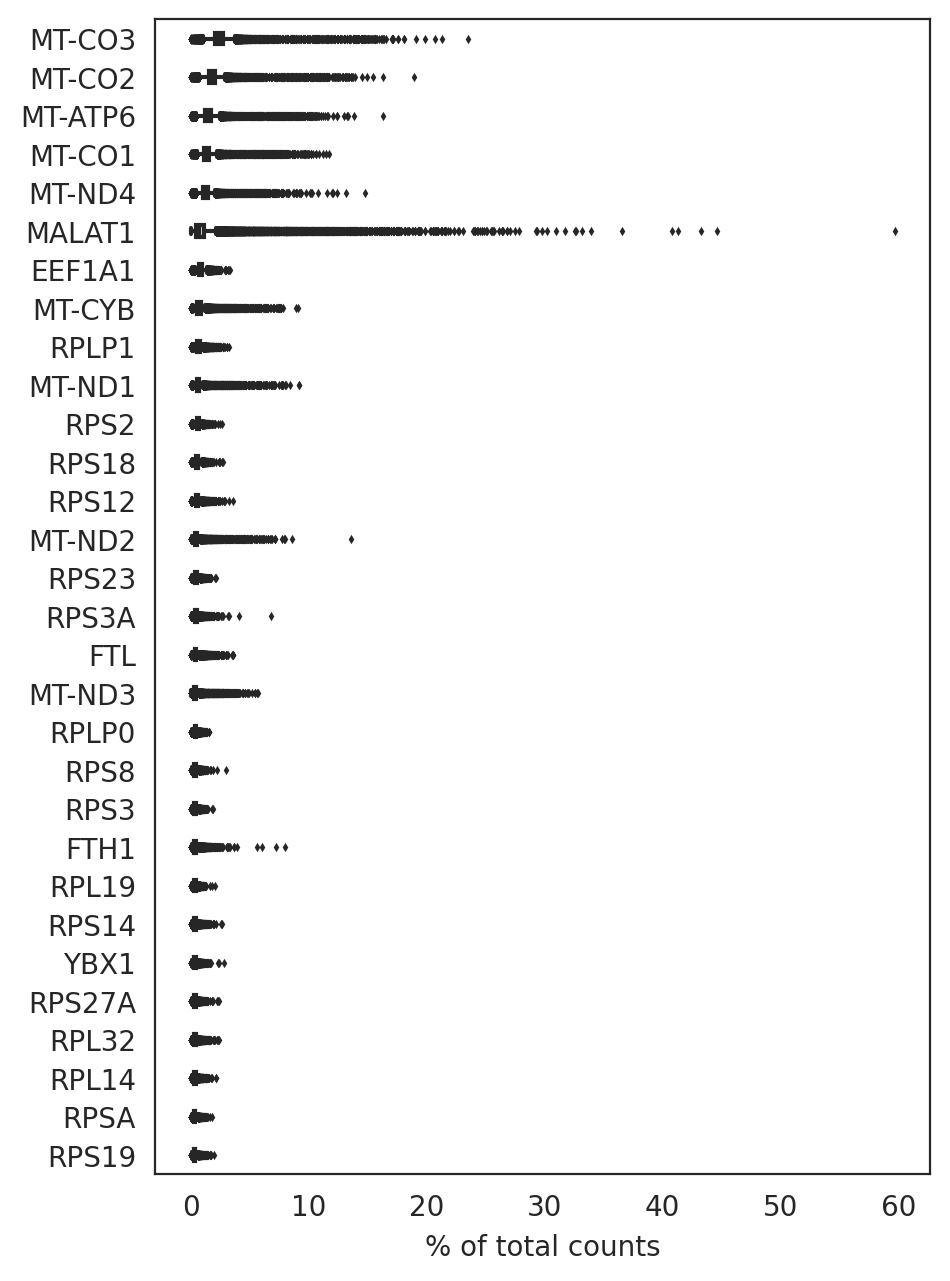

In [10]:
sc.pl.highest_expr_genes(expression_quantified, n_top=30, palette="Blues", width=.3)

In [11]:
expression_quantified.var['mt']   = expression_quantified.var_names.str.startswith(("MT-"))
expression_quantified.var['ribo'] = expression_quantified.var_names.str.startswith(("RPS","RPL"))
expression_quantified.var['mt'].sum(), expression_quantified.var['ribo'].sum(), 

(13, 103)

In [12]:
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

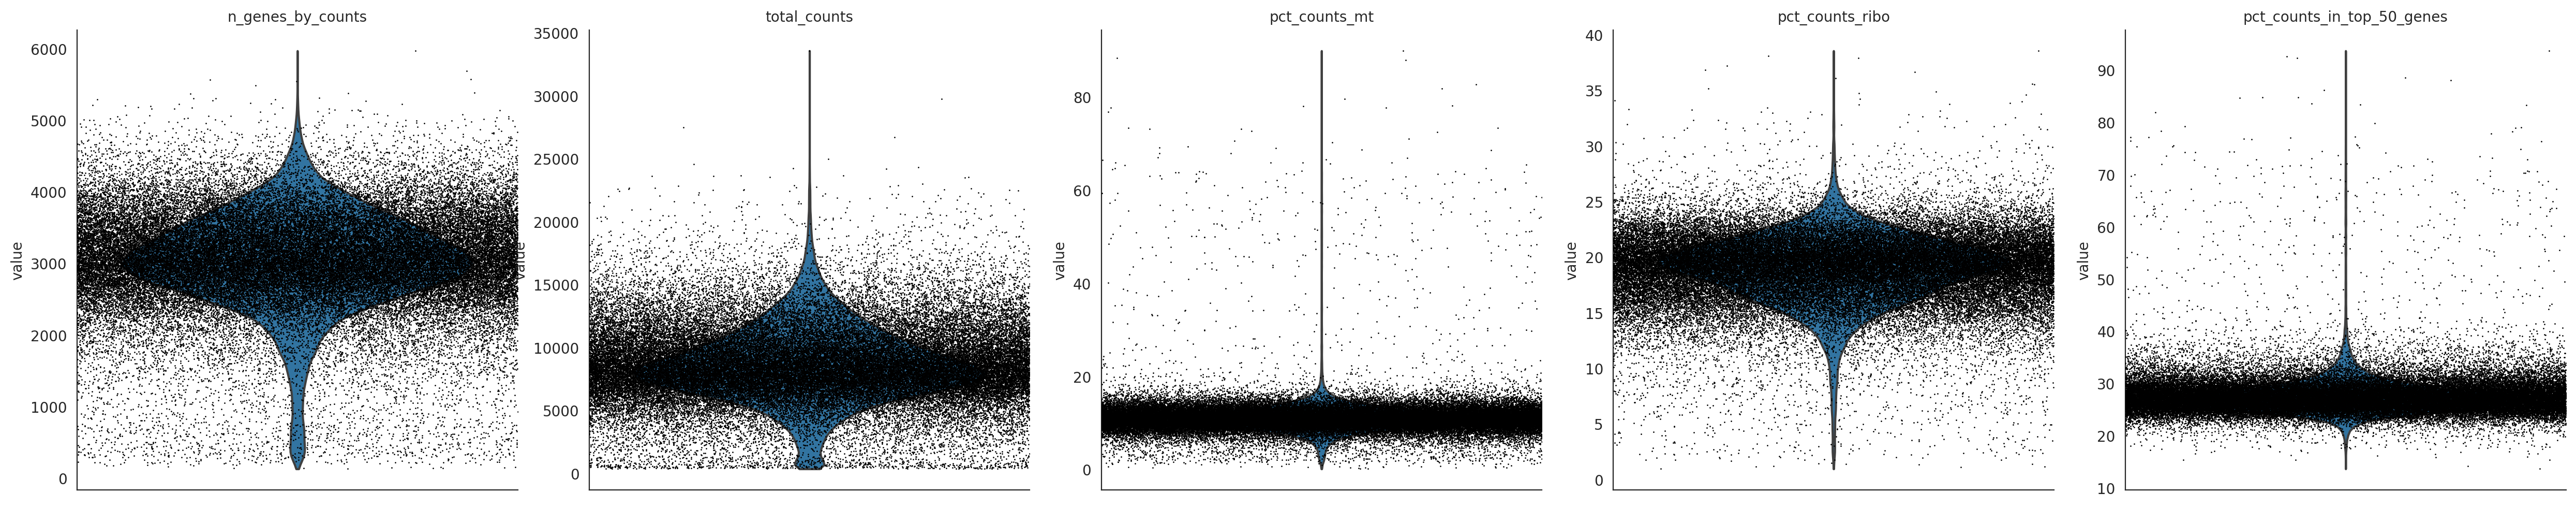

In [13]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.5, multi_panel=True)

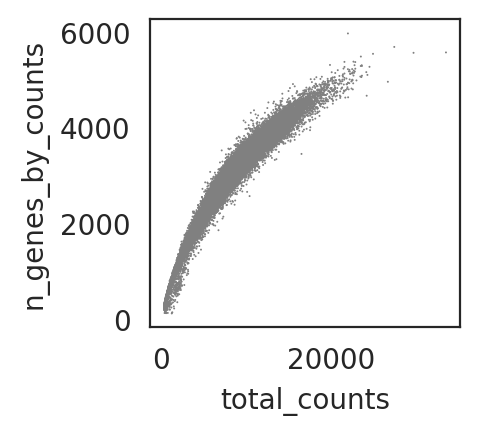

In [14]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [15]:
print("Number of cells: ", expression_quantified.n_obs)

# figure out the total counts == 95 percentile
thresh = np.percentile(expression_quantified.obs['total_counts'], 99)
print("95th percentile: ", thresh)

Number of cells:  60725
95th percentile:  17000.280000000006


In [16]:
expression_quantified = expression_quantified[expression_quantified.obs['total_counts'] < thresh, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  60117


In [17]:
expression_quantified = expression_quantified[expression_quantified.obs["total_counts"] >= 2000, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58809


In [18]:
expression_quantified = expression_quantified[expression_quantified.obs["pct_counts_in_top_50_genes"] <= 40, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58589


In [19]:
# filter for % mt
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_mt'] < 20, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58484


In [20]:
# filter for % ribo > 50%
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_ribo'] < 30, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58415


In [21]:
""" To verify the outcome of filtering cells """
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

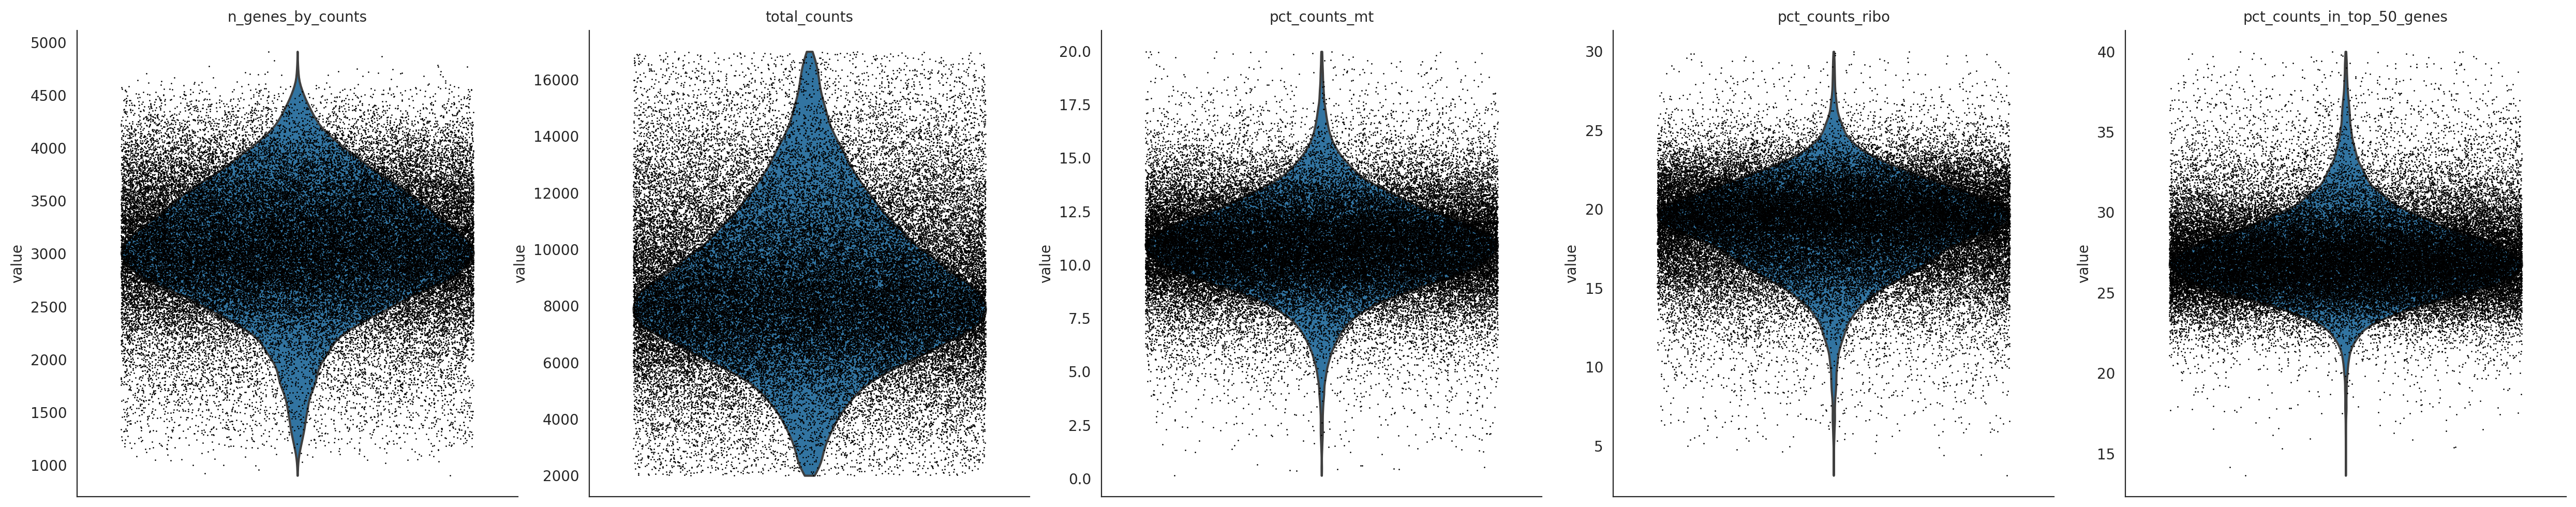

In [22]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

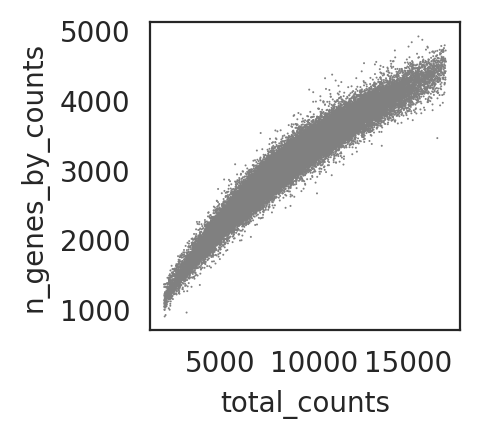

In [23]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [24]:
print("Number of genes: ", expression_quantified.n_vars)
gThresh = 10

sc.pp.filter_genes(expression_quantified, min_cells=gThresh)
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  33694
Number of genes:  18811


In [25]:
""" Specifically rescuing the perturbed genes """
rows = [np.where(expression_quantified.var_names == p)[0] 
        for p in set(expression_quantified.obs.perturbation) 
        if p in expression_quantified.var_names]
perturbedKeep = np.full(expression_quantified.n_vars, False)
perturbedKeep[rows] = True
np.sum(perturbedKeep)

61

In [26]:
mito_genes = expression_quantified.var_names.str.startswith('MT-')
ribo_genes = expression_quantified.var_names.str.startswith(("RPL","RPS"))
malat_gene = expression_quantified.var_names.str.startswith("MALAT1")

In [27]:
remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)
keep = np.invert(remove)
keep = keep | perturbedKeep
expression_quantified = expression_quantified[:,keep].copy()
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  18702


In [28]:
[idx for idx, n in enumerate(expression_quantified.var.index) if n.upper() == 'GAPDH']

[11182]

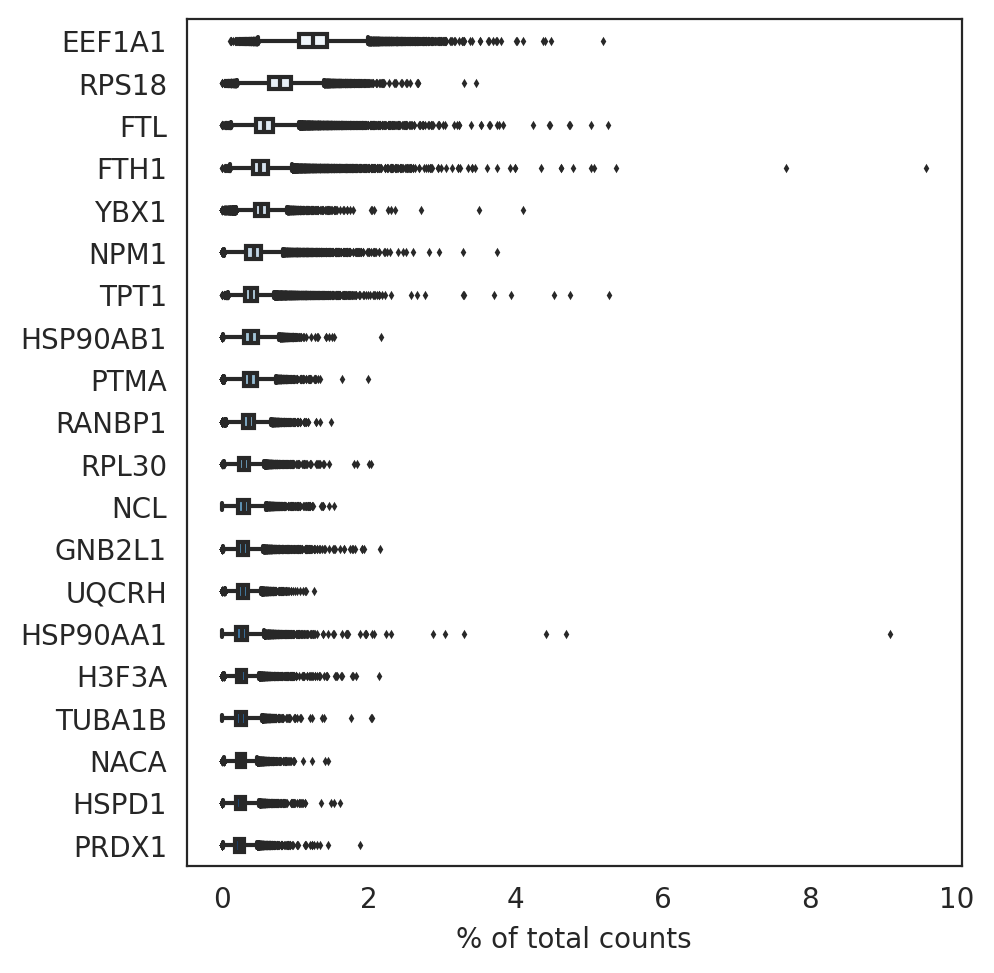

In [29]:
sc.pl.highest_expr_genes(expression_quantified, n_top=20, palette="Blues", width=.3)

In [30]:
""" To verify the outcome of filtering genes """
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

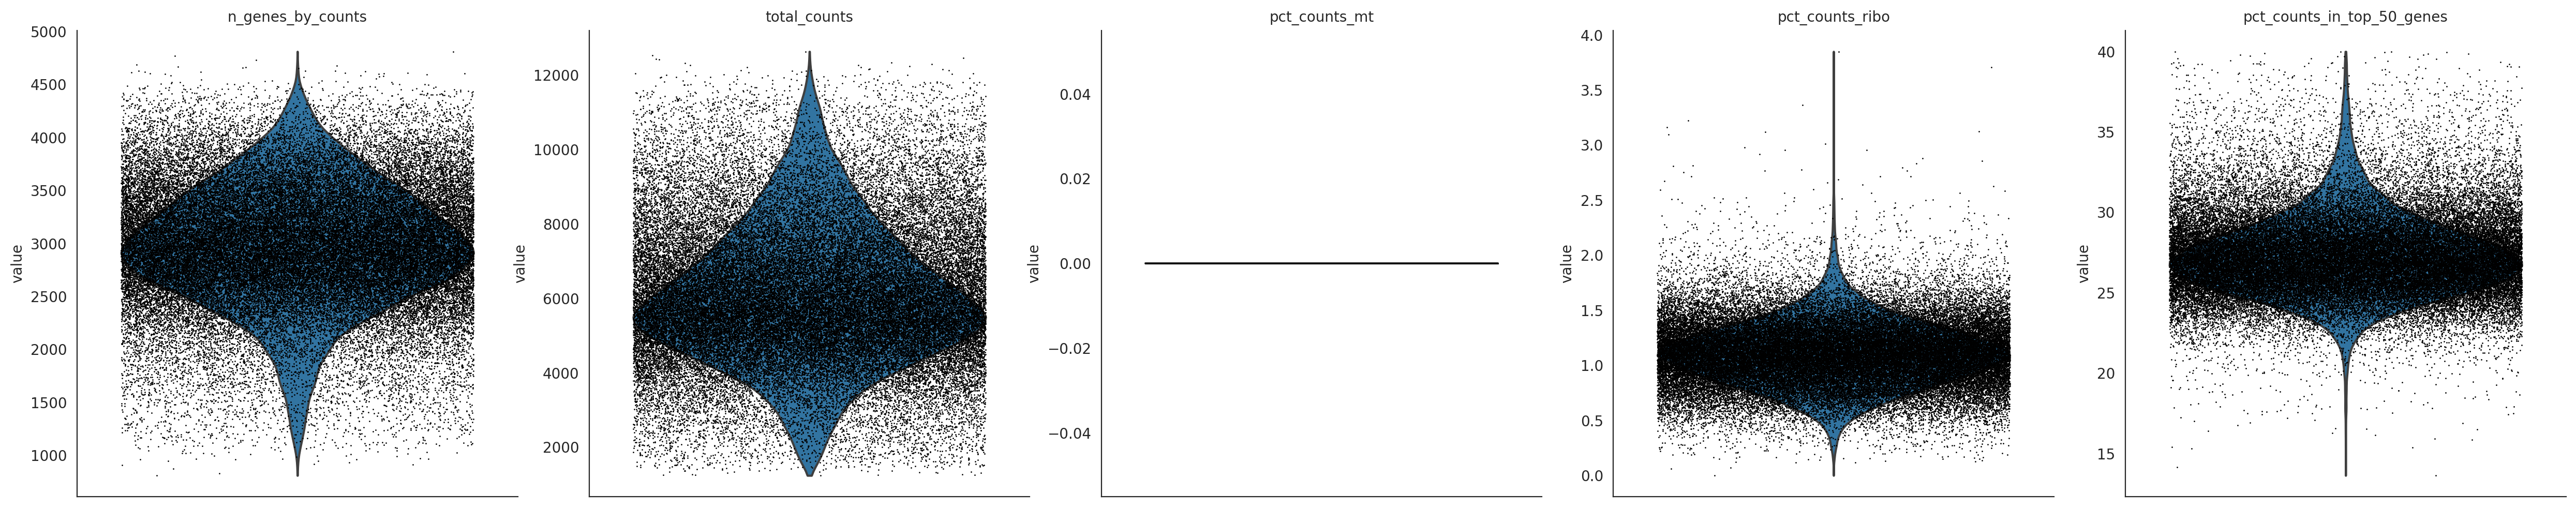

In [31]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

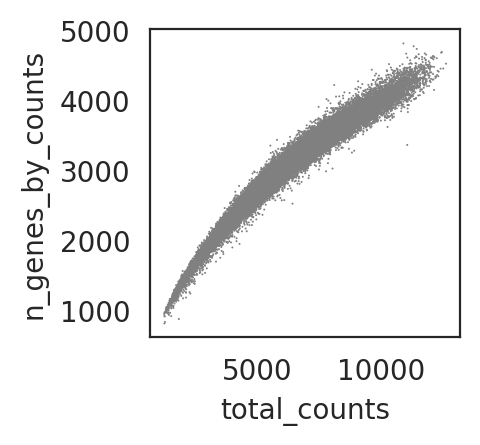

In [32]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

### Aggregate For Pseudo-Bulk

In [33]:
def aggregate(adata: anndata.AnnData):
    ad1 = adata.copy()
    
    uniqueGroup = np.array([f"{i}*{j}" for i,j in zip(ad1.obs.target_symbol, ad1.obs.type)])
    rowIndex    = np.array([uniqueGroup == i for i in set(sorted(uniqueGroup))])
    print(np.median([sum(r) for r in rowIndex]))
    newX        = np.squeeze([np.sum(ad1.X[r,:], axis=0) for r in rowIndex])
    newPerturb  = np.array([i.split("*")[0] for i in set(sorted(uniqueGroup))])
    newGuideRNA = np.array([i.split("*")[1] for i in set(sorted(uniqueGroup))])
    newControl  = np.array([True if 'Non-Targeting' in i else False for i in set(sorted(uniqueGroup))], dtype=bool)
    newControlInt  = np.array([1 if 'Non-Targeting' in i else 0 for i in set(sorted(uniqueGroup))], dtype=int)
    newObsMeta  = pd.DataFrame()
    newObsMeta['is_control']     = newControl
    newObsMeta['is_control_int'] = newControlInt
    newObsMeta['perturbation']   = newPerturb
    newObsMeta['guideRNA']       = newGuideRNA
    newAdata    = sc.AnnData(newX, 
                             var=ad1.var.copy(),
                             obs=newObsMeta)
    return newAdata
    
pseudobulk = aggregate(expression_quantified)

220.5


In [34]:
rows = [np.where(expression_quantified.var_names == p)[0] 
        for p in set(expression_quantified.obs.perturbation) 
        if p in expression_quantified.var_names]
perturbedKeep = np.full(expression_quantified.n_vars, False)
perturbedKeep[rows] = True
print(f"{np.sum(perturbedKeep)} columns to keep (perturbed genes)")
retainColumn = np.max(pseudobulk.X[~pseudobulk.obs.is_control], axis=0) > 100
retainColumn = retainColumn | perturbedKeep
pseudobulk = pseudobulk[:, retainColumn].copy()
print(f"{pseudobulk.shape} is post-filtering shape.")

61 columns to keep (perturbed genes)
(254, 6651) is post-filtering shape.


### Normalization on pseudobulk

In [35]:
pseudobulk.raw = pseudobulk

In [36]:
pseudobulk.X = ingestion.deseq2Normalization(pseudobulk.X.T).T

### Visualize Normalization Effort

In [37]:
z2 = pseudobulk.copy()

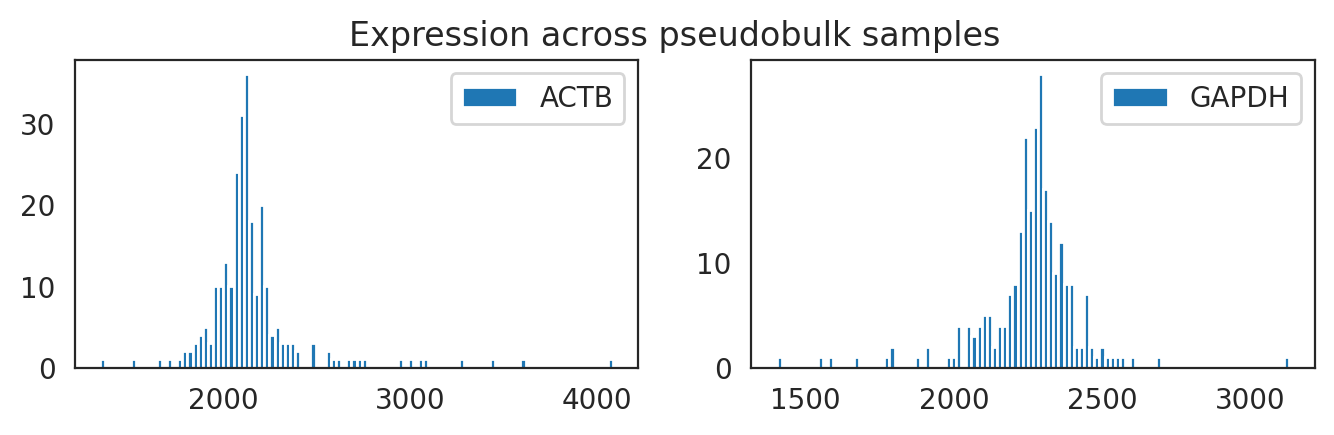

In [38]:
""" Sanity check: expression for house keeping genes are relatively stable """
fig, axes = plt.subplots(1, 2, figsize=(8,2))
axes[0].hist(z2.X[:, [idx for idx, n in enumerate(pseudobulk.var.index) if n.upper() == 'ACTB']], bins=100, label="ACTB")
axes[1].hist(z2.X[:, [idx for idx, n in enumerate(pseudobulk.var.index) if n.upper() == 'GAPDH']], bins=100, label="GAPDH")
axes[0].legend()
axes[1].legend()
plt.suptitle("Expression across pseudobulk samples")
plt.show()

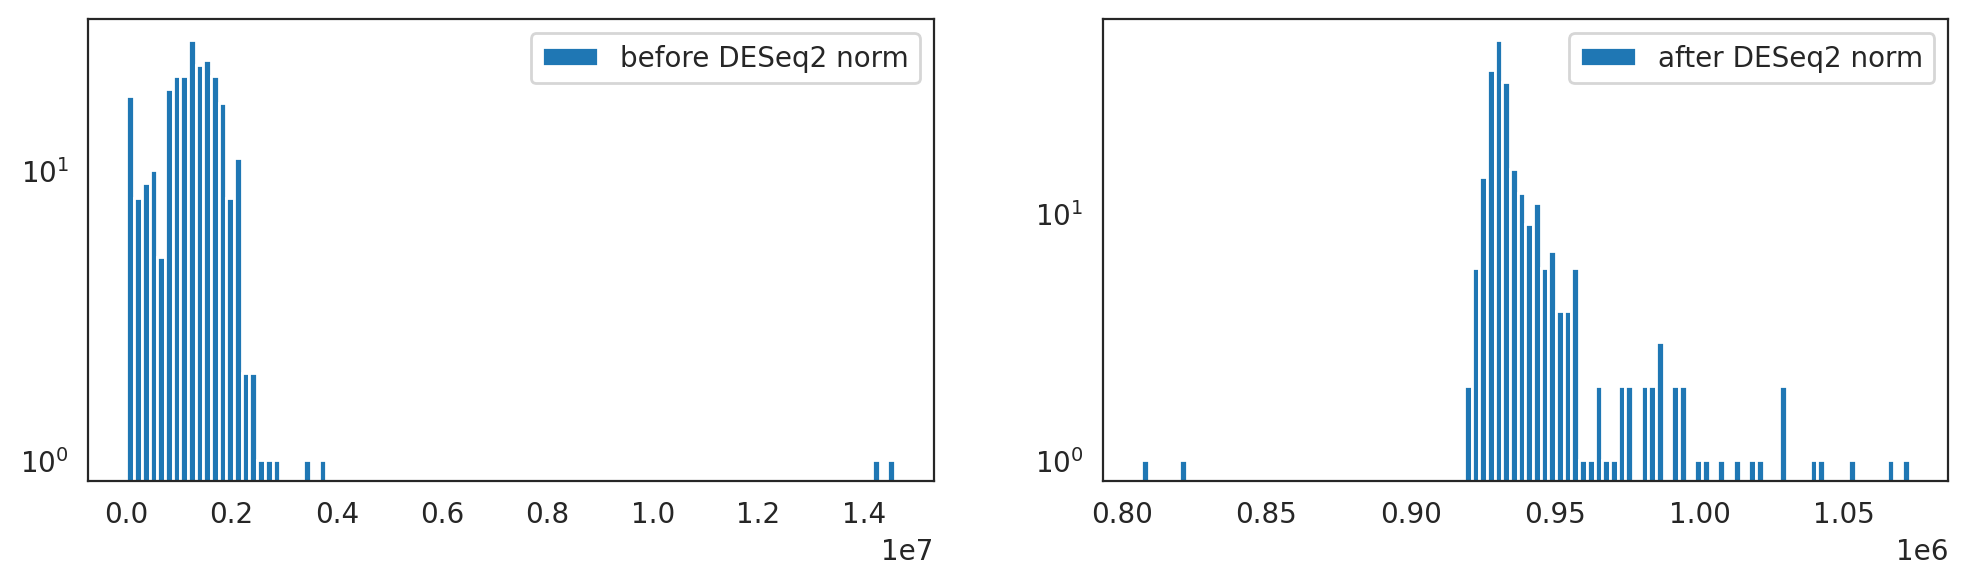

In [39]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(pseudobulk.raw.X.sum(axis=1), bins=100, log=True, label="before DESeq2 norm")
axes[1].hist(pseudobulk    .X.sum(axis=1), bins=100, log=True, label= "after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

is_control  is_control_int perturbation   guideRNA
46       False               0        HSPD1        1_2
54       False               0        HSPD1  1_control
91       False               0        HSPD1  control_2

(6629,) (6629,)


PearsonRResult(statistic=0.009324145317509873, pvalue=0.4478329030878989)

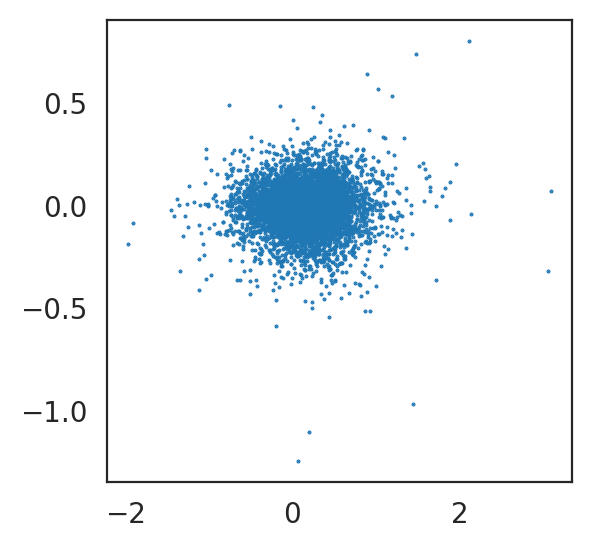

In [40]:
TFBePerturb = 'HSPD1'
display(z2[z2.obs.perturbation == TFBePerturb].obs)
expr1 = z2[z2.obs.perturbation == TFBePerturb].X[0,:]
expr2 = z2[z2.obs.perturbation == TFBePerturb].X[2,:]

controlExpr  = pseudobulk[pseudobulk.obs.is_control, :].X
c1 = np.median(controlExpr.copy(), axis=0)

plt.figure(figsize=(3,3))
logFC1 = np.log(z2[z2.obs.perturbation == TFBePerturb].X[1,:]/c1)
logFC2 = np.log(z2[z2.obs.perturbation == TFBePerturb].X[2,:]/c1)
validGeneEntry = np.isfinite(logFC1) & np.isfinite(logFC2)
logFC1 = logFC1[validGeneEntry]
logFC2 = logFC2[validGeneEntry]
print(logFC1.shape, logFC2.shape)
plt.scatter(logFC1, logFC2, s=0.2)
pearsonr(logFC1, logFC2)

### Check Consistency between perturbation and measured

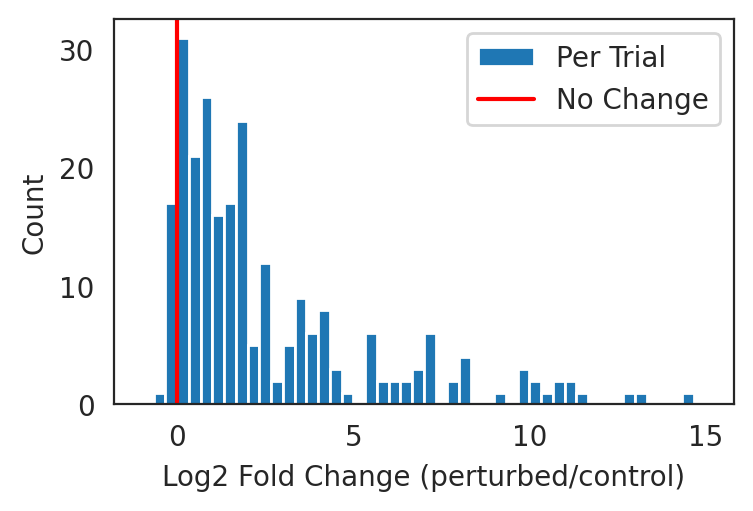

Counter({'Yes': 225, 'No': 21, 'NA': 8})

In [41]:
# If verbose is set to True, display disconcordant trials and their controls
status, logFC = ingestion.checkConsistency(pseudobulk, 
                                           perturbationType="overexpression", 
                                           group=None,
                                           verbose=False) 
pseudobulk.obs["consistentW/Perturbation"] = status
pseudobulk.obs["logFC"] = logFC
Counter(status)

### QC !!

In [42]:
""" Remove perturbations that appear to have failed """
pseudobulk_filtered = pseudobulk[pseudobulk.obs['consistentW/Perturbation'] != 'No'].copy()

### Check Consistency between replications

[41 47] AIRE 1
[ 90  99 140] ASCL1 2
[12 14 80] ATF4 3
[ 97 200 224] ATF5 4
[ 64  96 196 199 223] BACH2 5
[153 197] CCDC51 6
[  7  84 142 166 181] CDKN1A 7
[ 11  24  34 193 231] CDKN1B 8
[ 62 141 217] CERKL 9
[ 67 107 108 150 220] COL2A1 10
[ 59  81 129 149 198] COX5A 11
[ 66  87  95 221] CREB1 12
[  6  45  74  98 113] DDIT3 13
[  1 109 154 177 201] DDIT4 14
[ 19 139 148] EIF2S1 15
[151 203 211] EOMES 16
[ 56 175 186] ETS2 17
[ 50  60 207] FOXC1 18
[ 52 208 232] GATA3 19
[ 13  46  72 190 225] HHEX 20
[ 26  30 187] HIC2 21
[  3 103 124 131 226] HIF1A 22
[ 43 133 138 209 214] HOXD13 23
[ 28 132 147 171] HSF1 24
[  0 121 136 168 188] HSPA9 25
[44 51 86] HSPD1 26
[ 76 106 137 213 228] IGDCC3 27
[ 21  37  82 120 146] IRF1 28
[  5  48 227] KLF1 29
[164 216 222] LHX4 30
[ 25  31 156 195 205] MAP2K3 31
[ 38 125 127 173 202] MAP2K6 32
[ 63  85 126] MAPK1 33
[ 88 101 134 135 230] MEIS2 34
[167 180 184 192 212] MTOR 35
[  9  77 114 158 165] NEUROD1 36
[  2 116 159] NEUROG2 37
[ 20  22  89 145 179

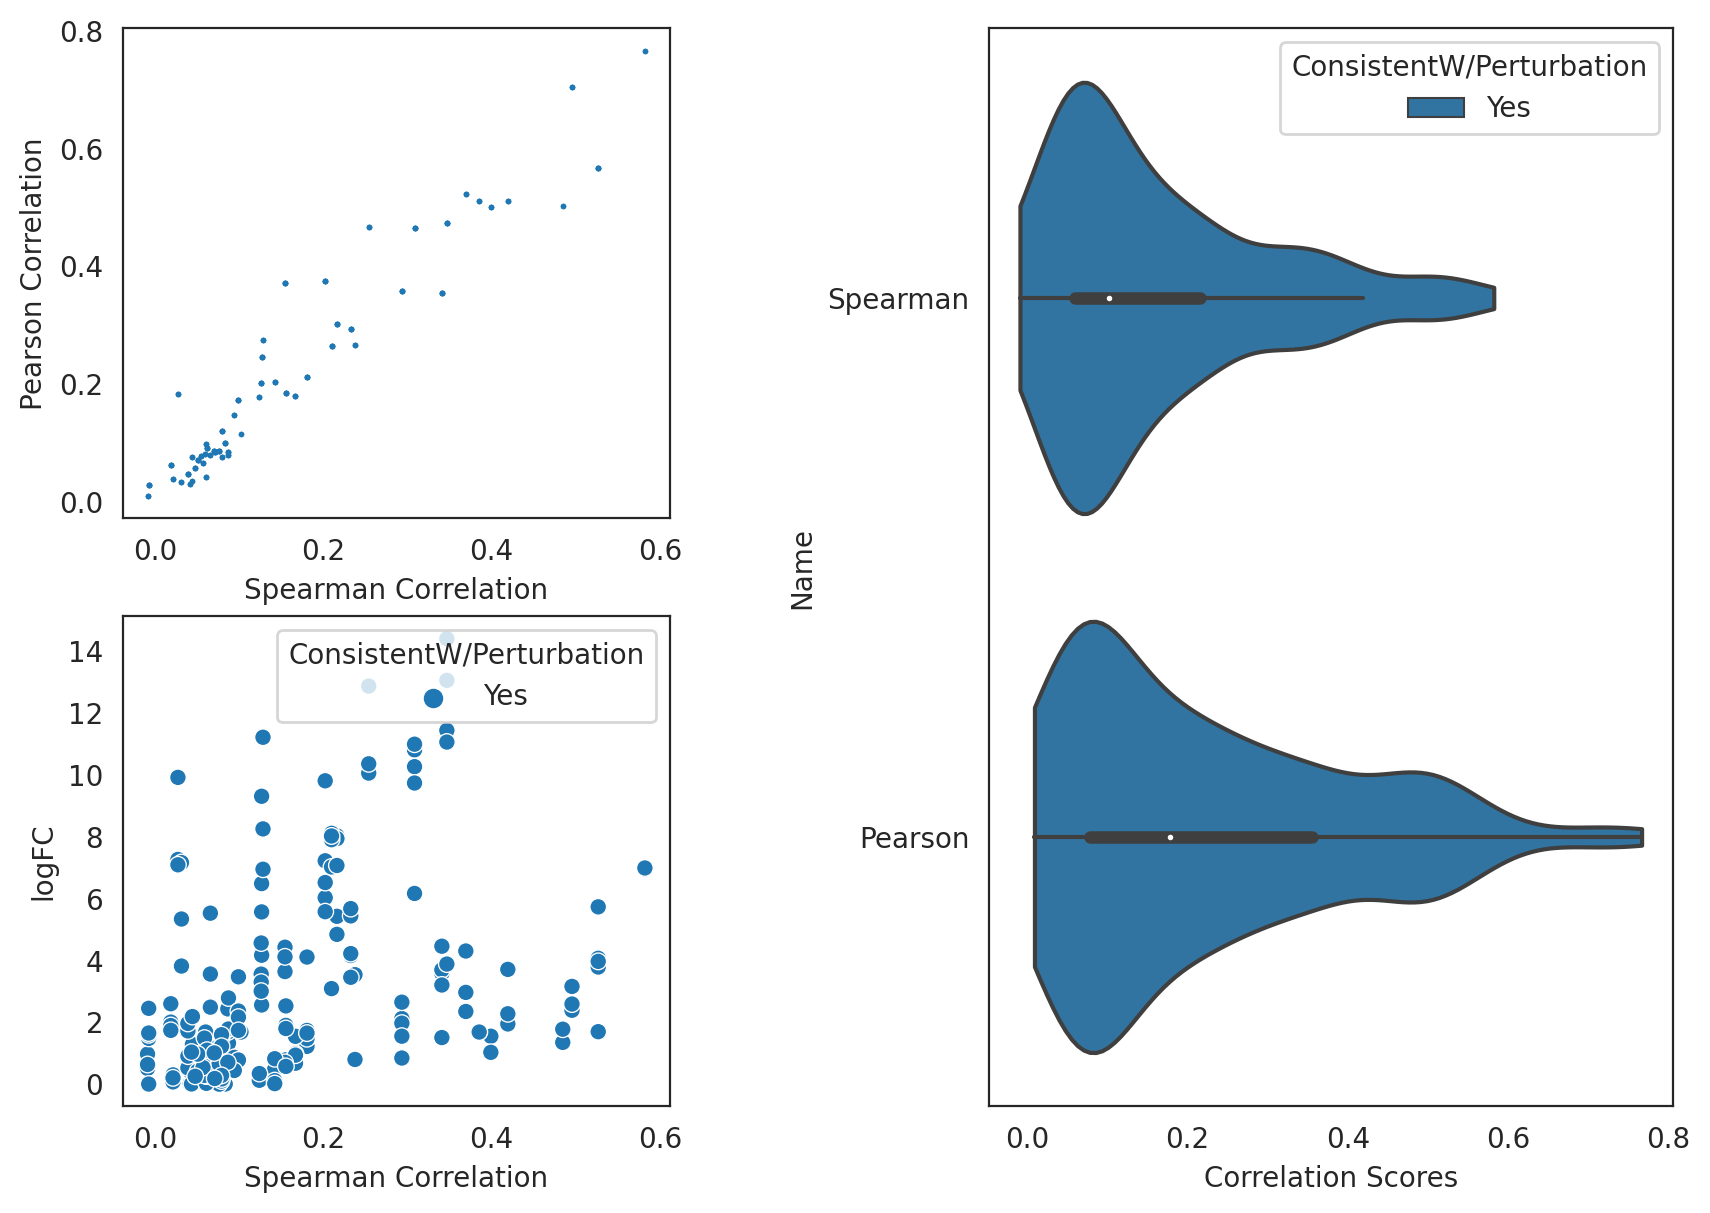

In [43]:
correlations = ingestion.computeCorrelation(pseudobulk_filtered, verbose=True)
pseudobulk_filtered.obs["spearmanCorr"] = correlations[0]
pseudobulk_filtered.obs[" pearsonCorr"] = correlations[1]

pseudobulk = pseudobulk_filtered.copy()

### Compute the Magnitude of Perturbation Effect

In [44]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

In [45]:
""" If want to look at bigness on TF only """
TFVar = [i for i,p in enumerate(pseudobulk.var.index) if p in TFDict or p in EpiDict]
pseudobulkTFOnly = pseudobulk[:, TFVar].copy()
ingestion.quantifyEffect(adata=pseudobulkTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=False, 
                         prefix="TFOnly")

ingestion.quantifyEffect(adata=pseudobulk, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None,
                         diffExprFC=False, 
                         prefix="")

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    pseudobulk.obs[f"TFOnly{m}"] = pseudobulkTFOnly.obs[f"TFOnly{m}"]

195
0 AIRE 0.0 0.1278425455093383 0.0957220196723938 5.360741138458252 3.025809833206996
1 ASCL1 2.0 0.161111518740654 0.1212973594665527 7.580086708068848 2.9390867856414165
2 ATF4 1.0 0.111798919737339 0.0837589651346206 4.987577438354492 3.0066691331503
3 ATF5 0.0 0.1149908006191253 0.084106221795082 5.835231304168701 2.9343334301879045
4 BACH2 0.0 0.0796282067894935 0.0559201426804065 4.218928813934326 3.049102909773961
5 CCDC51 327.0 0.7125750184059143 0.5870984792709351 13.989239692687988 1.0327950246652795
6 CDKN1A 1.0 0.2208764851093292 0.168684184551239 9.180397987365724 2.6057590251489016
7 CDKN1B 0.0 0.2277939468622207 0.1675812304019928 10.041678428649902 2.541512496368165
8 CEBPB 0.0 0.1711817234754562 0.125806838274002 7.727429389953613 2.9367859481964924
9 CERKL 1.0 0.0971044972538948 0.0721485391259193 4.096303939819336 3.0344603048766463
10 COL2A1 0.0 0.1572818756103515 0.1161305755376815 6.595796585083008 2.7781941504908336
11 COX5A 0.0 0.0785251334309578 0.0574759319

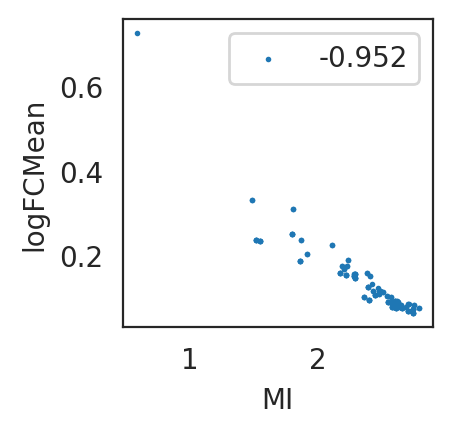

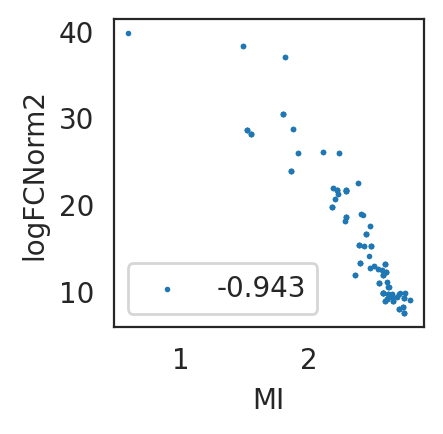

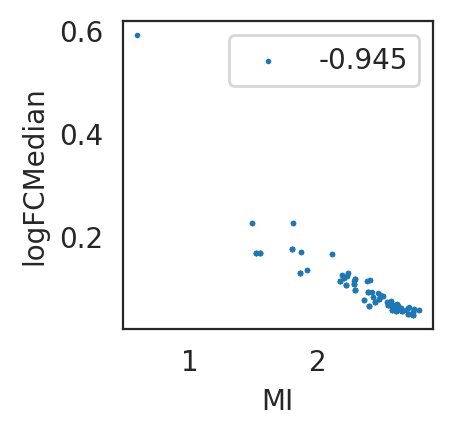

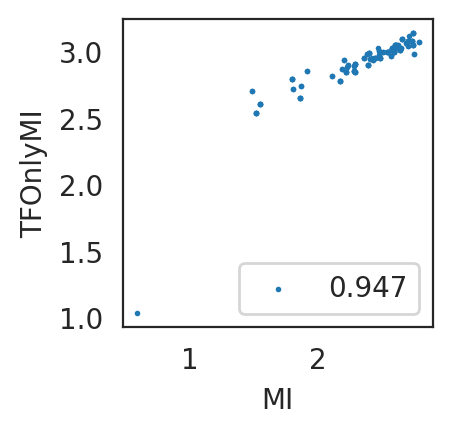

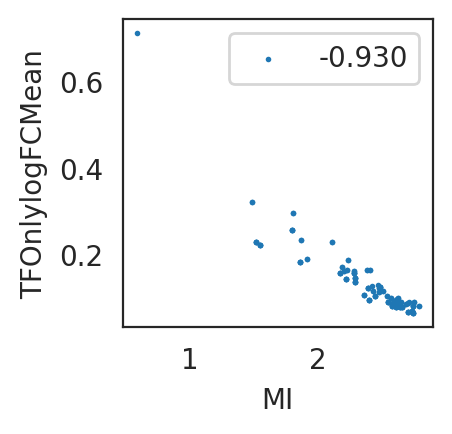

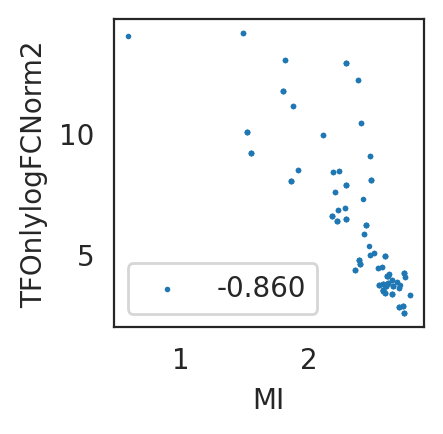

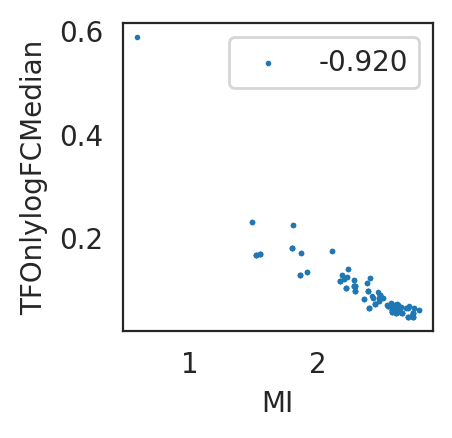

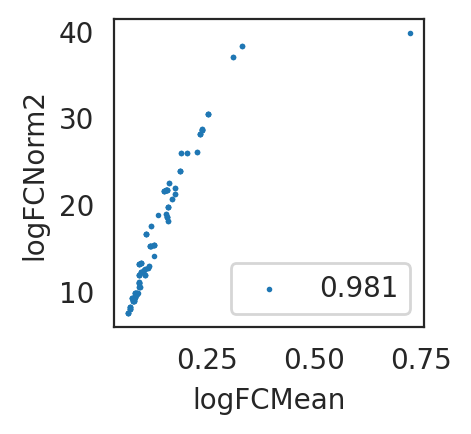

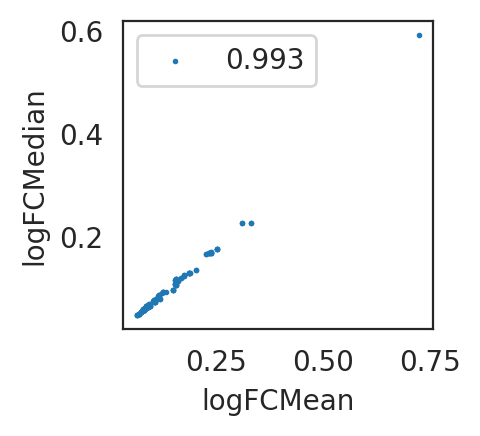

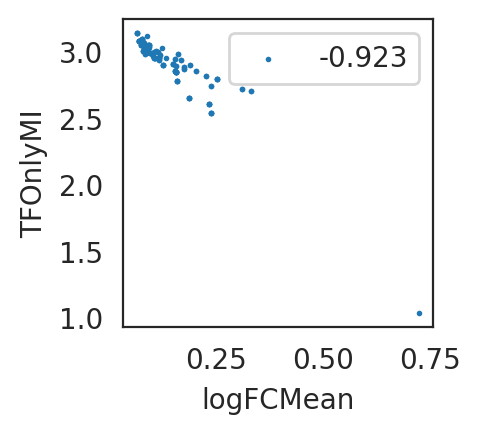

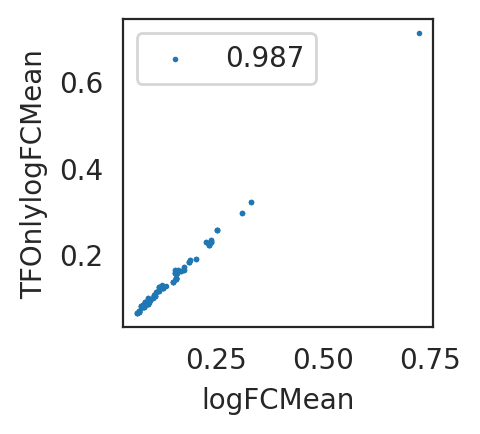

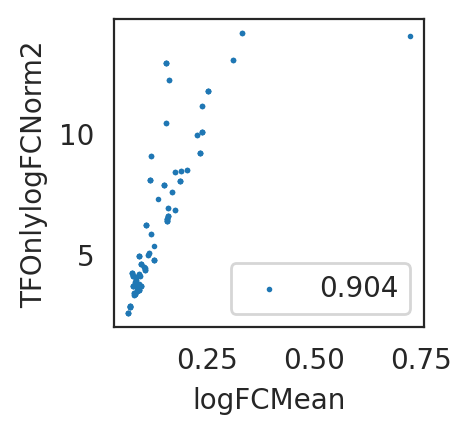

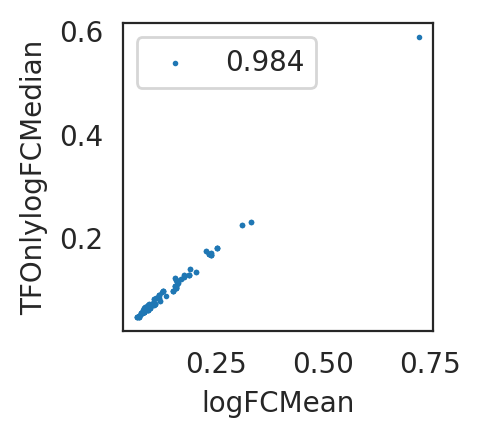

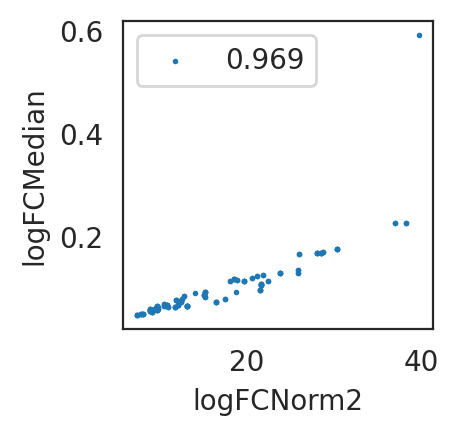

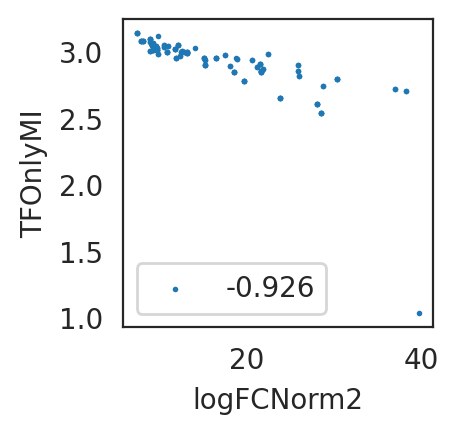

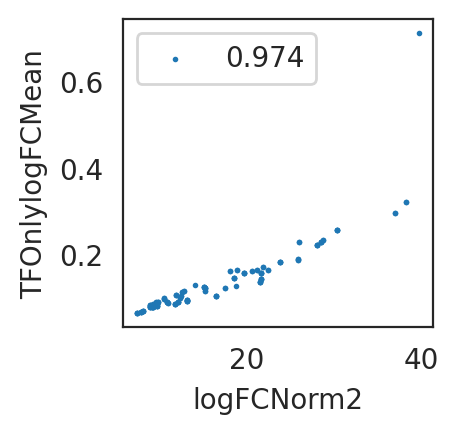

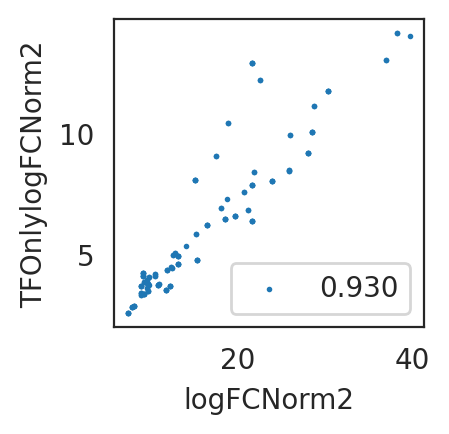

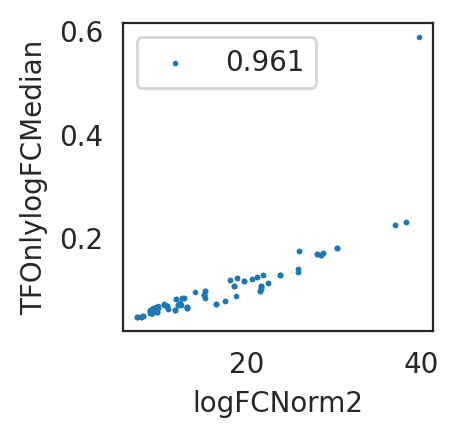

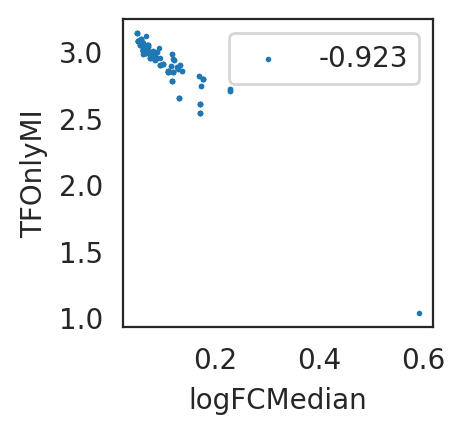

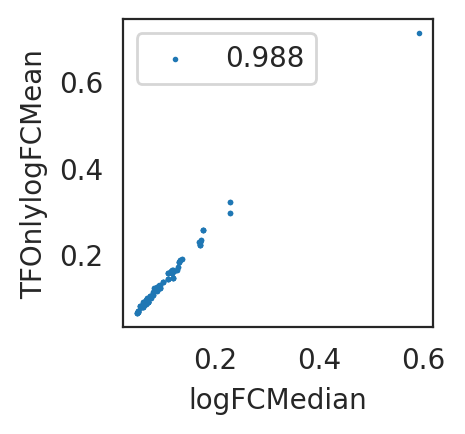

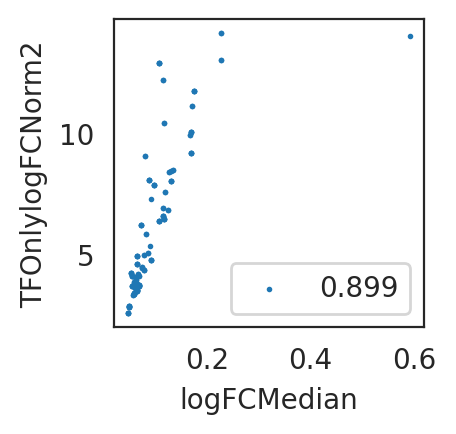

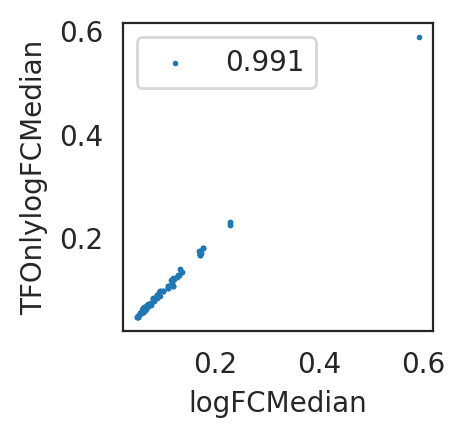

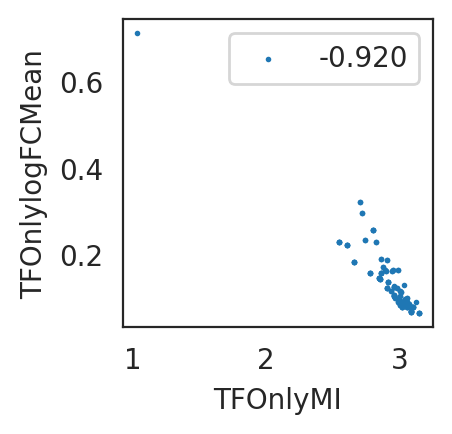

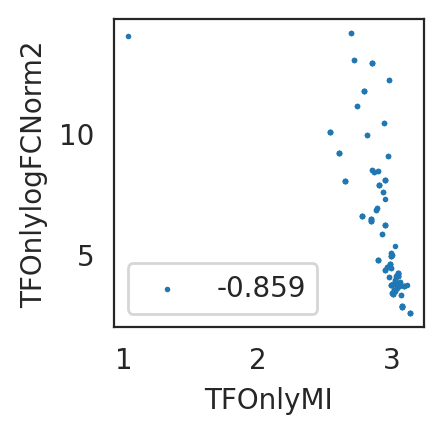

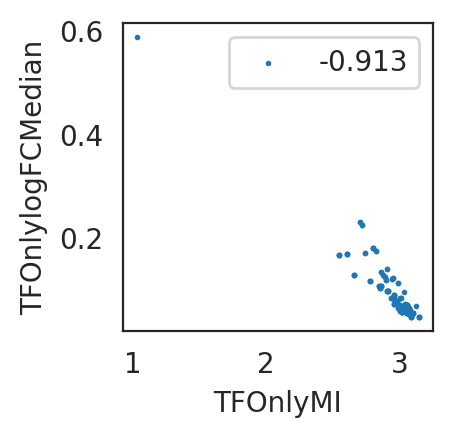

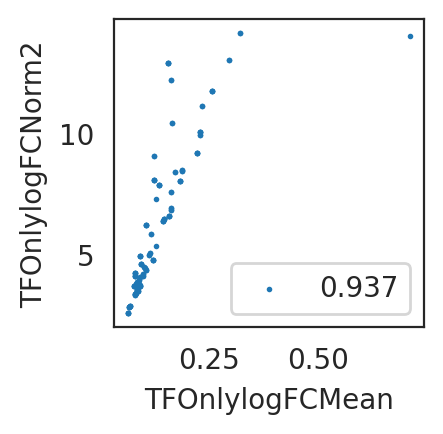

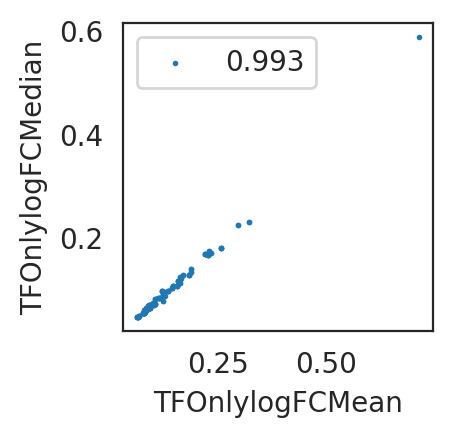

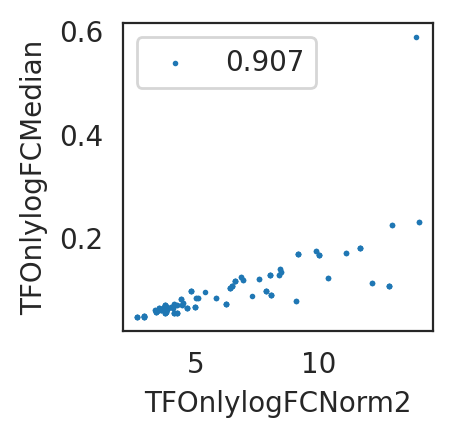

In [46]:
metricOfInterest = ["MI", "logFCMean", "logFCNorm2", "logFCMedian", 
                    "TFOnlyMI", "TFOnlylogFCMean", "TFOnlylogFCNorm2", "TFOnlylogFCMedian"]
ingestion.checkPerturbationEffectMetricCorrelation(pseudobulk, metrics=metricOfInterest)

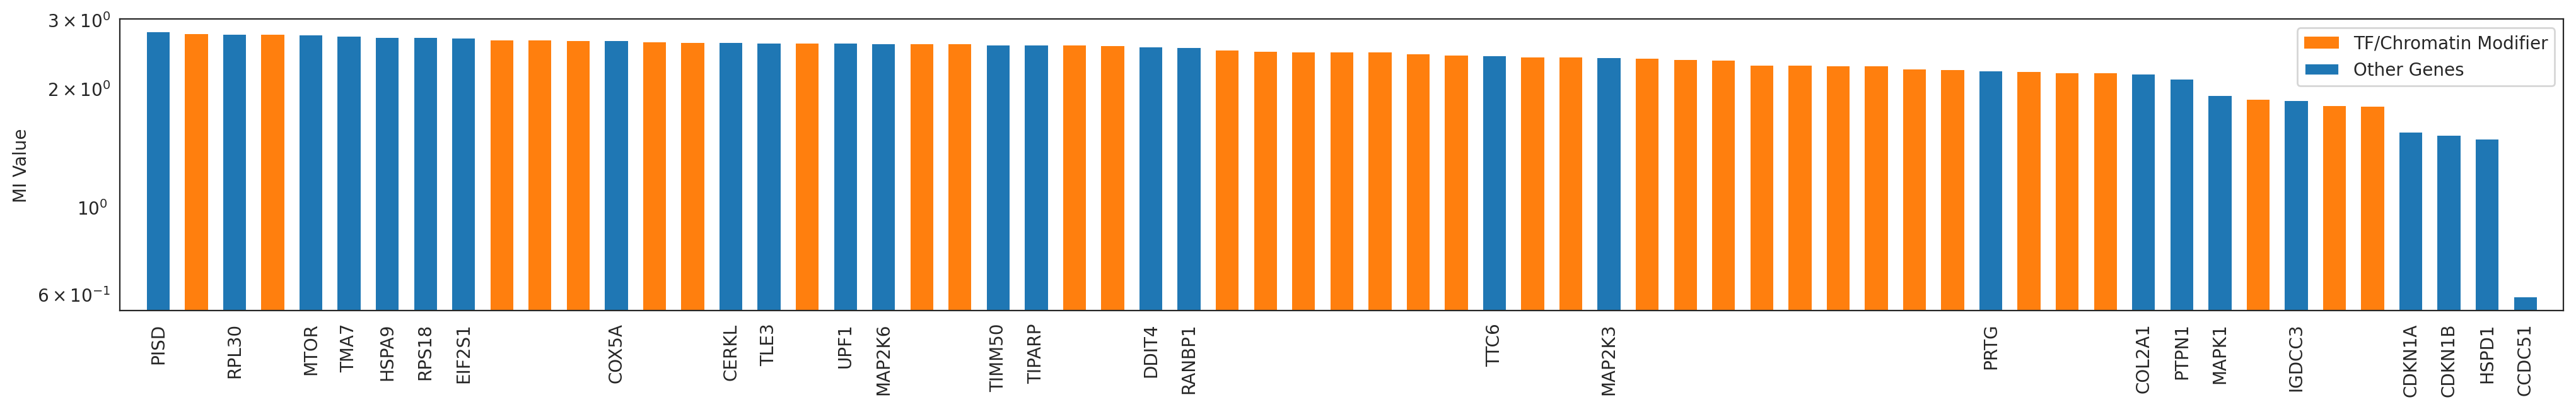

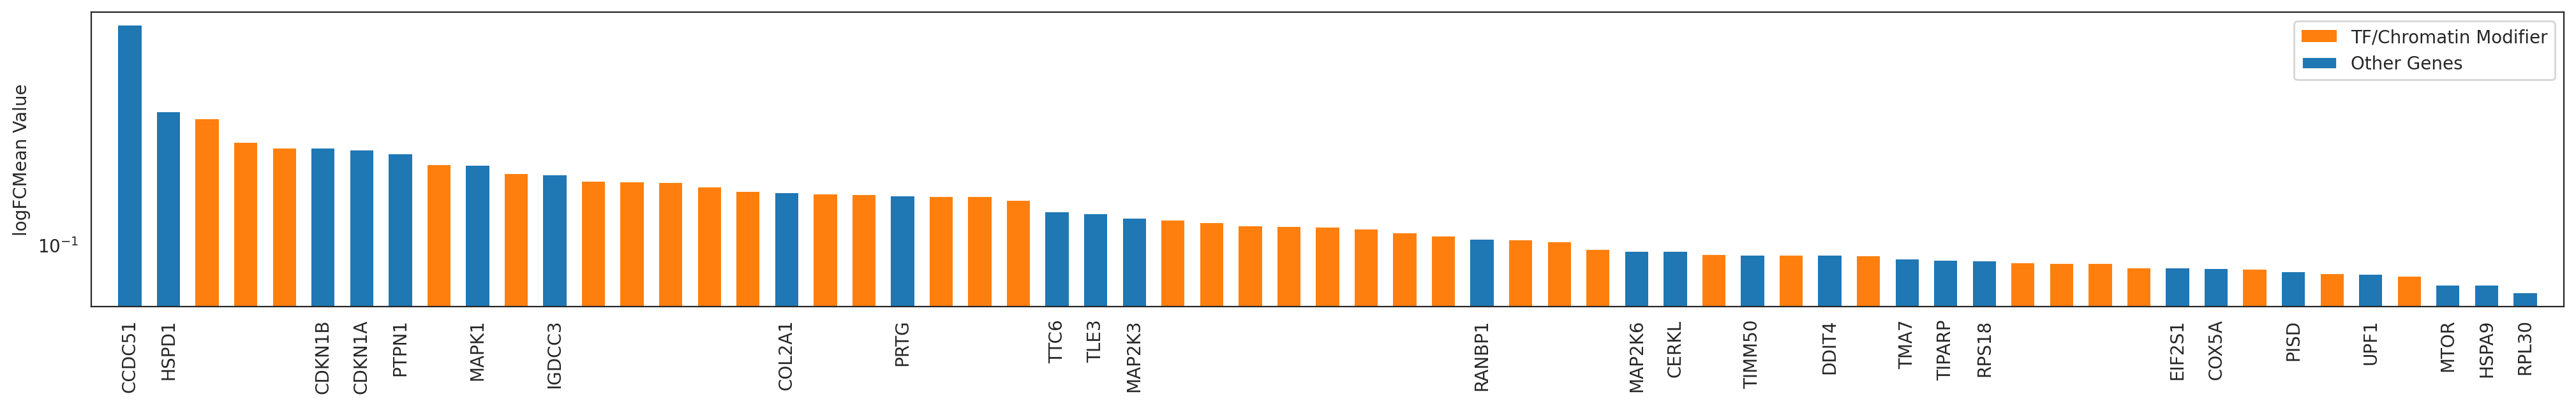

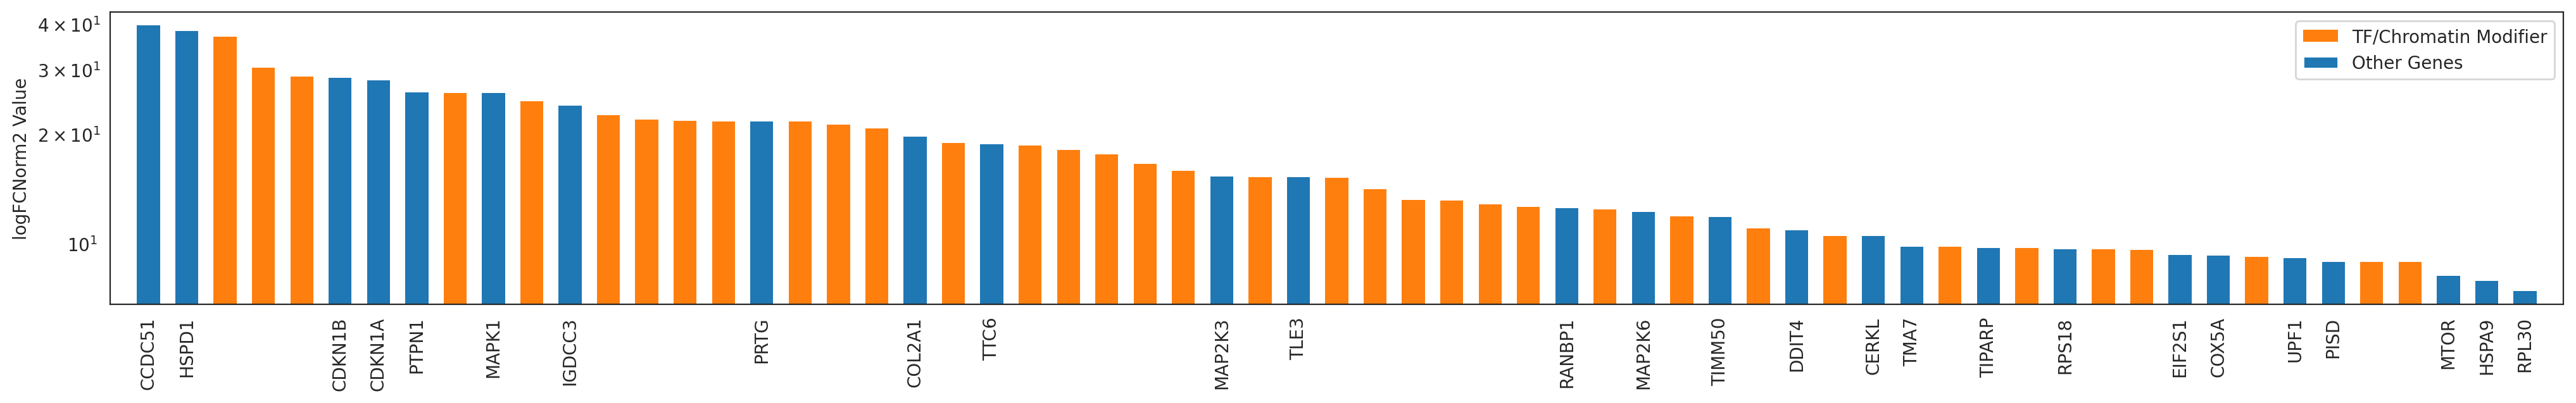

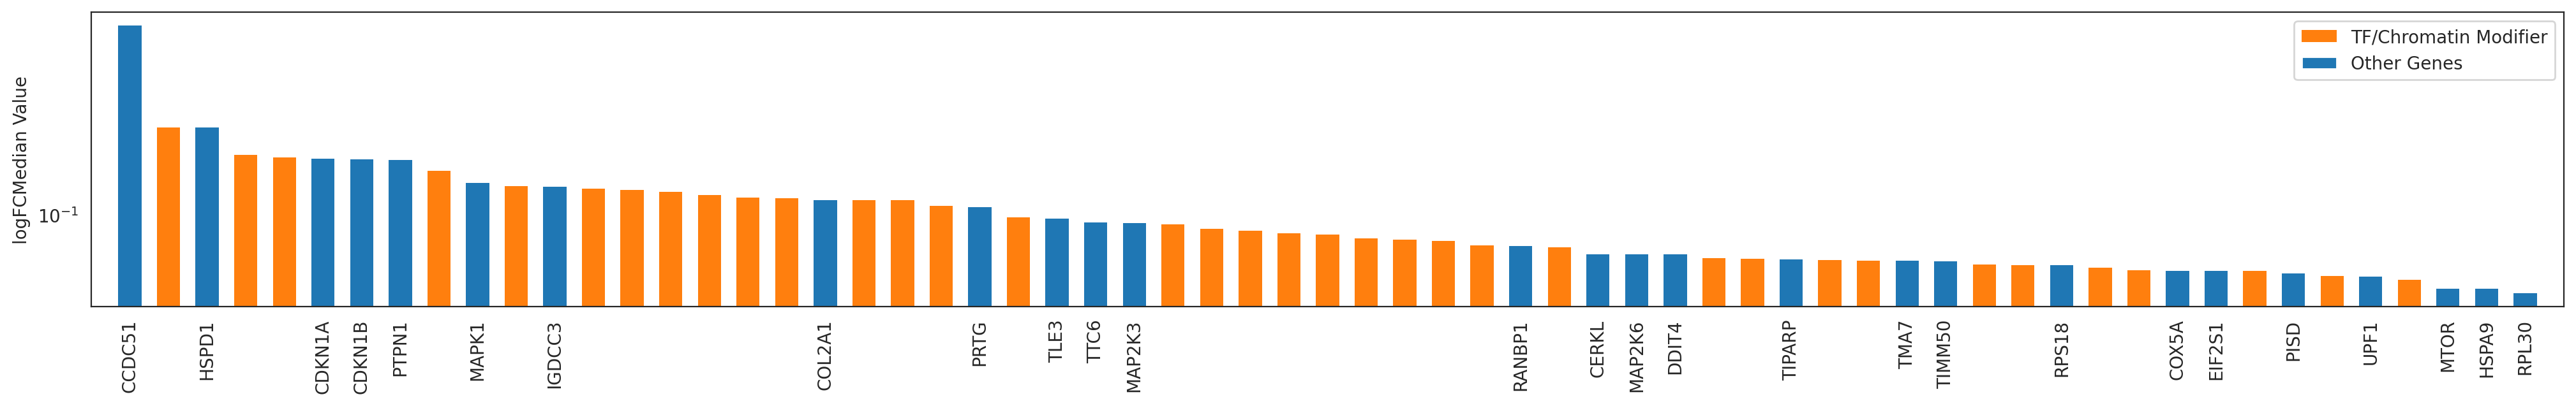

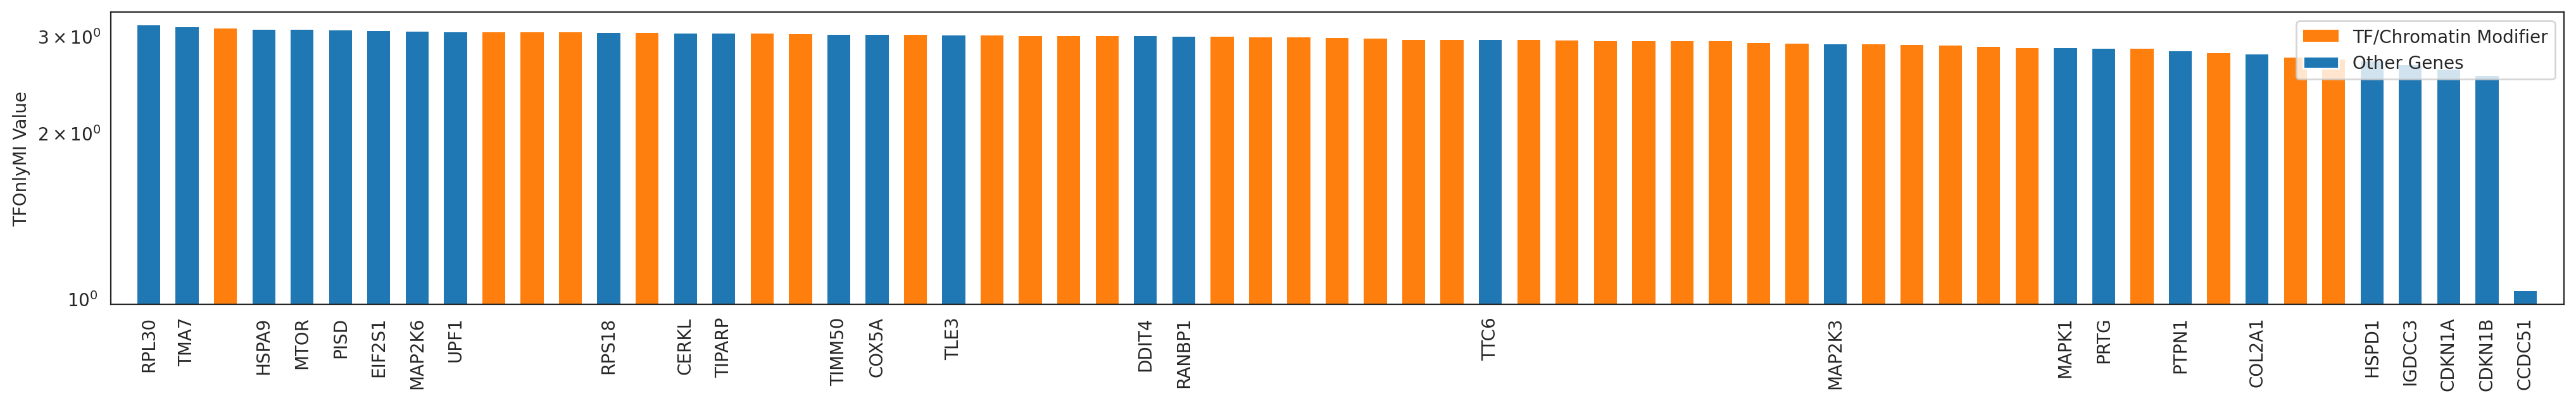

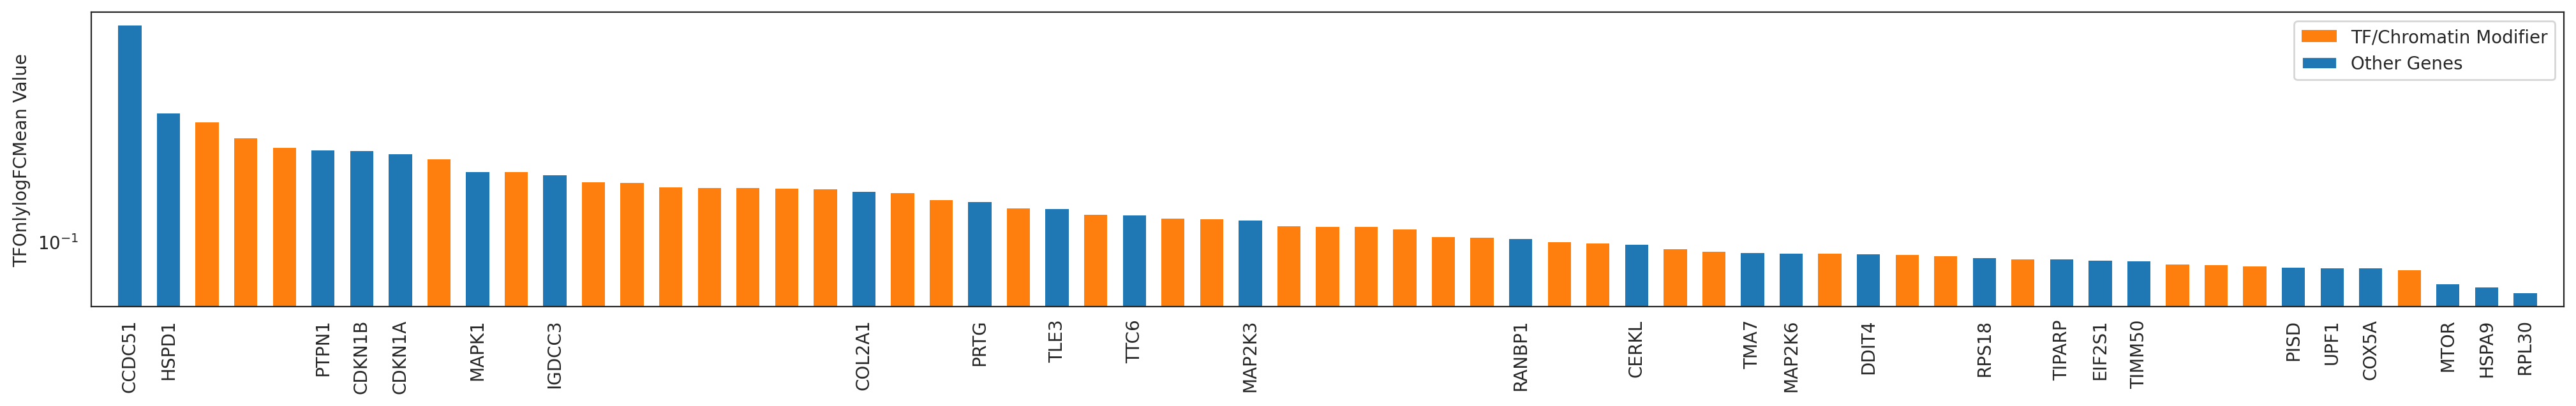

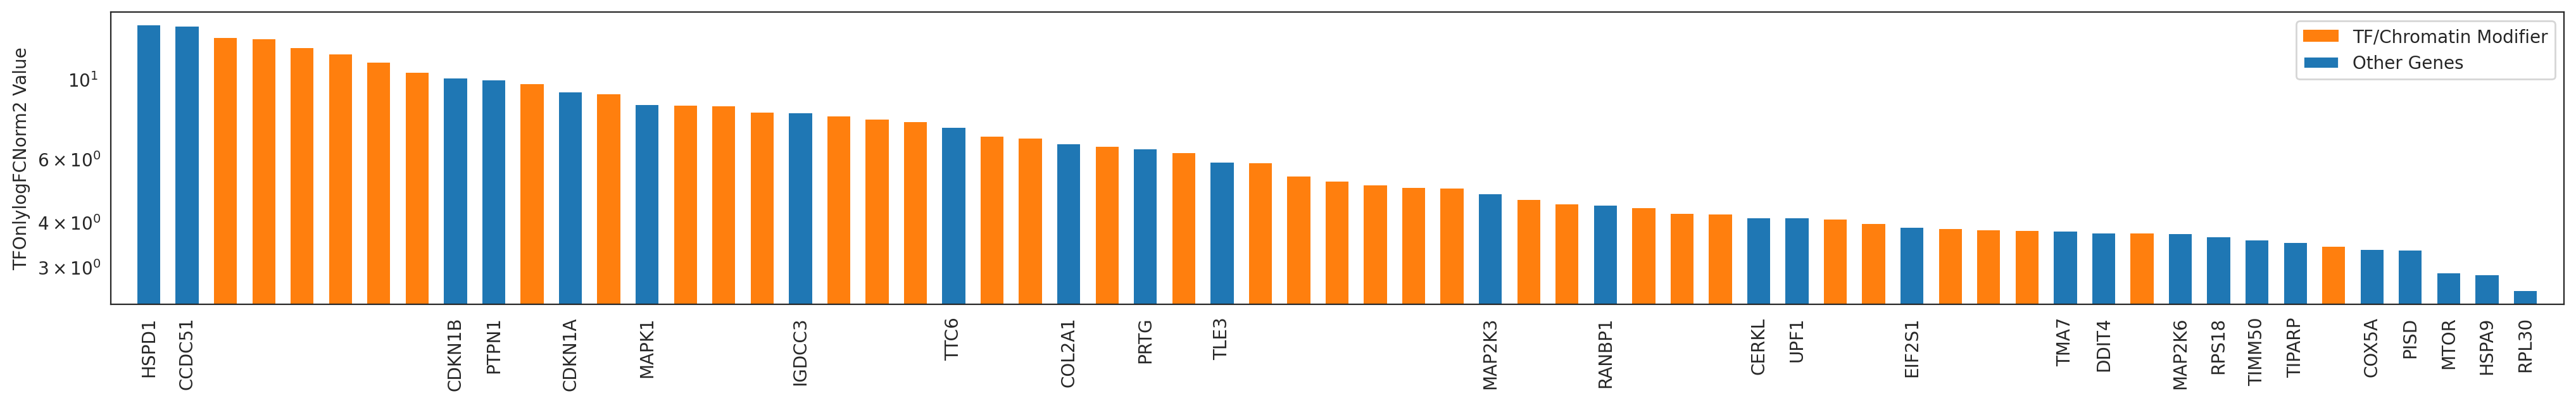

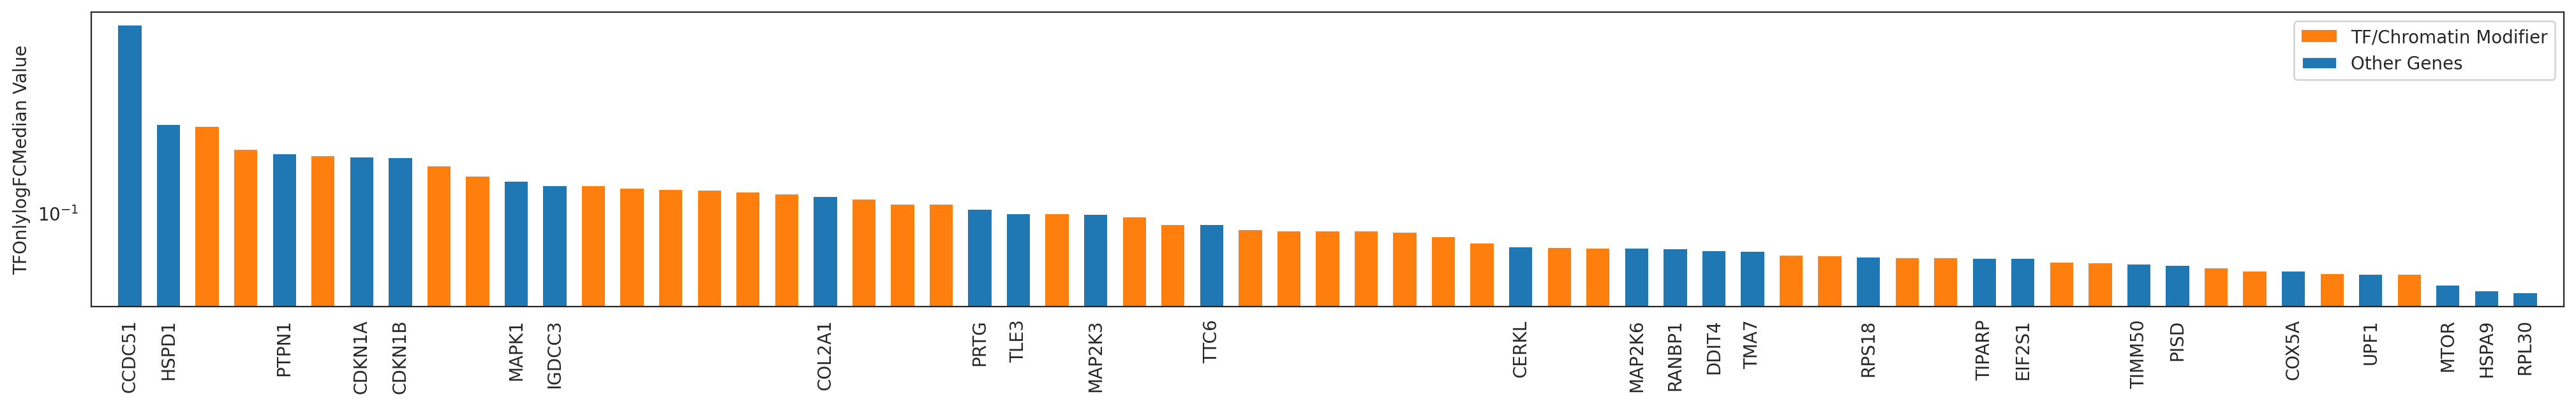

In [47]:
ingestion.visualizePerturbationEffect(pseudobulk, metrics=metricOfInterest, TFDict=TFDict, EpiDict=EpiDict)

In [48]:
sorted(set([(i,j) for i,j in pseudobulk.obs[['perturbation', 'logFCNorm2']].to_numpy()]), key=lambda x: x[1])

[('Non-Targeting', -999.0),
 ('RPL30', 7.402176380157471),
 ('HSPA9', 7.904314041137695),
 ('MTOR', 8.14639663696289),
 ('HIF1A', 8.892013549804688),
 ('CREB1', 8.896040916442871),
 ('PISD', 8.896894454956055),
 ('UPF1', 9.102328300476074),
 ('BACH2', 9.176976203918455),
 ('COX5A', 9.245380401611328),
 ('EIF2S1', 9.293618202209473),
 ('NRF1', 9.614248275756836),
 ('ZNF574', 9.626866340637209),
 ('RPS18', 9.634584426879885),
 ('ZNF236', 9.724875450134276),
 ('TIPARP', 9.736477851867676),
 ('FOXC1', 9.780801773071287),
 ('TMA7', 9.809747695922852),
 ('CERKL', 10.475380897521973),
 ('PPARGC1A', 10.494694709777832),
 ('DDIT4', 10.87732219696045),
 ('SREBF1', 11.022944450378418),
 ('TIMM50', 11.808578491210938),
 ('HSF1', 11.856918334960938),
 ('MAP2K6', 12.185992240905762),
 ('TFAP4', 12.381932258605955),
 ('RANBP1', 12.499120712280272),
 ('ATF4', 12.614701271057127),
 ('HIC2', 12.82667636871338),
 ('NPM1', 13.120346069335938),
 ('DDIT3', 13.177556037902832),
 ('AIRE', 14.07151985168457),


233 number of points are plotted


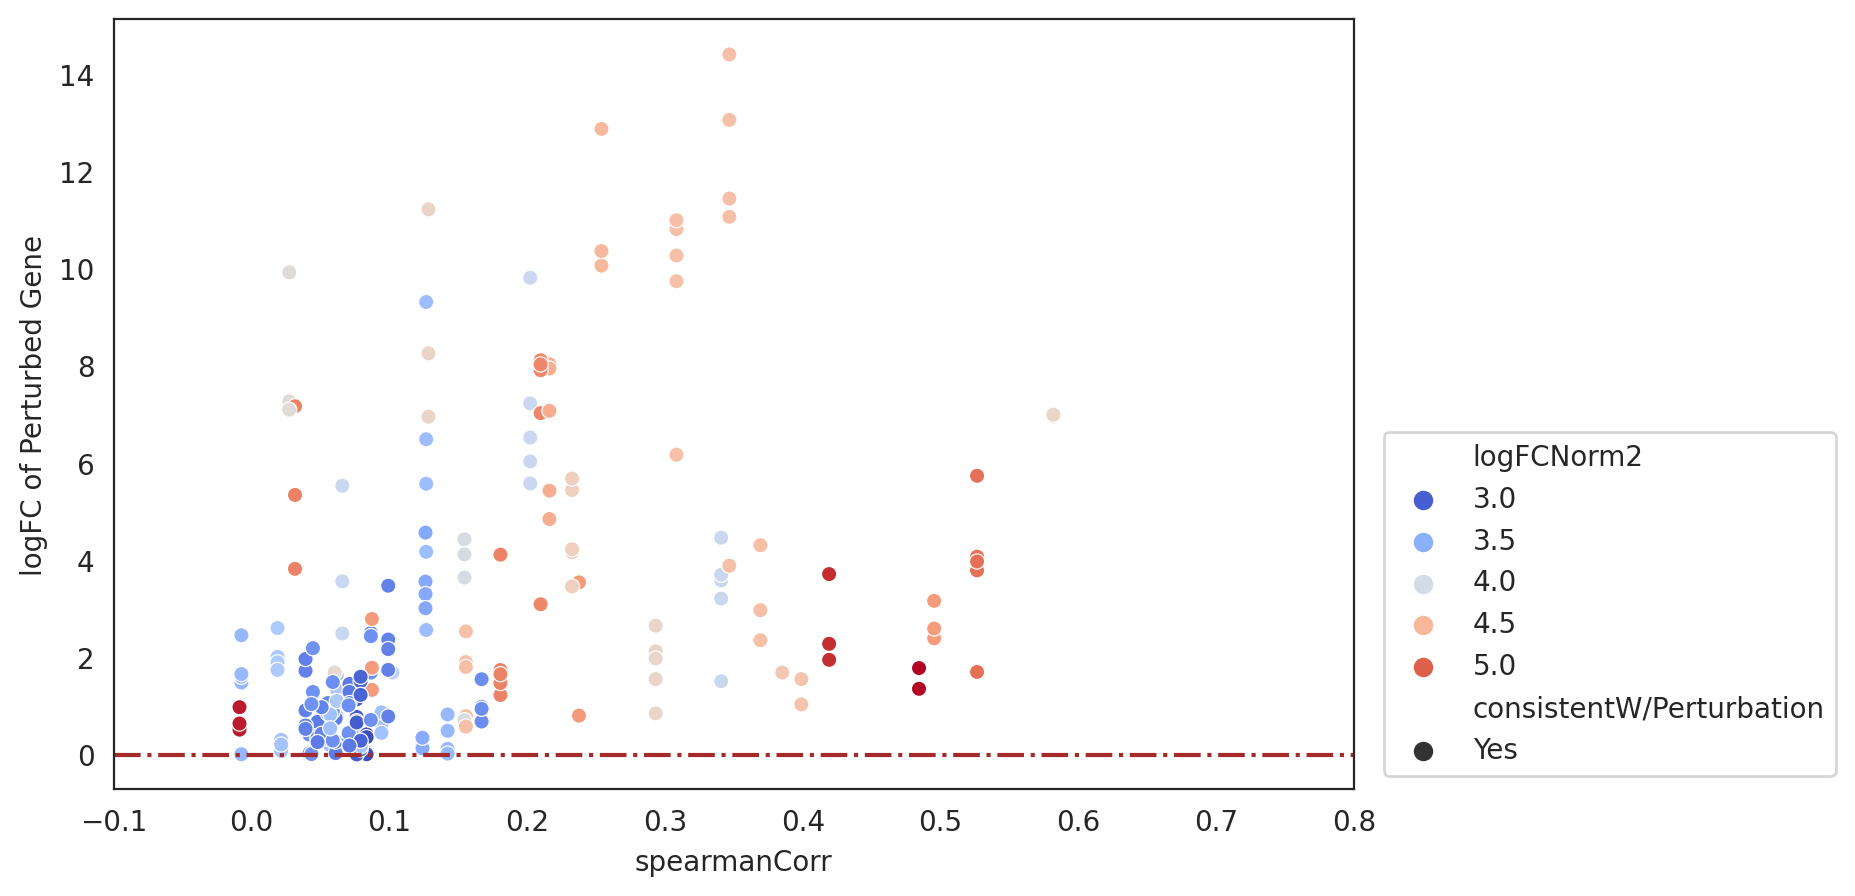

In [49]:
temp = pseudobulk.copy()

""" If wish to see more clearer, by masking the ones with 
much higher logFC norm2 values """
# temp = pseudobulk[(pseudobulk.obs.perturbation != 'CCDC51') 
#                   & (pseudobulk.obs.perturbation != 'HSPD1') 
#                   & (pseudobulk.obs.perturbation != 'SPI1') 
#                   & (pseudobulk.obs.perturbation != 'CEBPB')
#                  ].copy()

""" If you wish to see the magnitude of perturbation effect more clearer,
    i.e. a smoother gradient of the color shift, feel free to uncomment
    the line below, which takes the log of the norm2 """
temp.obs['logFCNorm2'] = np.log2(temp.obs['logFCNorm2'])

ingestion.visualizePerturbationMetadata(temp, 
                                        x="spearmanCorr", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="logFCNorm2", 
                                        markers=['o', '^'], 
                                        xlim=[-0.1, 0.8])

### Further Sanity Check (why a handful perturbagen have low correlation but high perturbation effect)

In [50]:
z1 = pseudobulk.X.copy()
z2 = pseudobulk.copy()
z2.X = ingestion.deseq2Normalization(pseudobulk.X.copy().T).T

array([ 5.348202 ,  5.8594265,  5.8770394,  6.3846154,  6.650594 ,
        7.110346 ,  7.651963 ,  7.978128 , 18.31578  , 18.856384 ],
      dtype=float32)

array([6343, 3978])

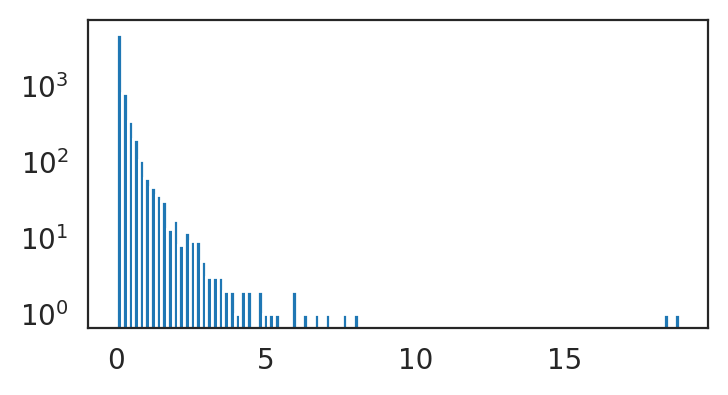

ArrayView([[9650.669  ,  143.5964 ],
           [9127.096  ,  153.6893 ],
           [5767.587  ,  143.46945]], dtype=float32)

gene_ids    feature_types  n_cells_by_counts  mean_counts  \
FTL     ENSG00000087086  Gene Expression              58408    36.439560   
VPS26A  ENSG00000122958  Gene Expression              34370     0.945254   

        log1p_mean_counts  pct_dropout_by_counts  total_counts  \
FTL              3.653923               0.011983     2128617.0   
VPS26A           0.674862              41.162373       55217.0   

        log1p_total_counts     mt   ribo  n_cells  
FTL              15.240120  False  False    58408  
VPS26A           11.575524  False  False    34370

In [51]:
normedLogFC = np.log2(z2[z2.obs.perturbation == 'HSPD1'].X / np.median(z2[z2.obs.is_control].X, axis=0))
normedLogFCSqed = np.median(normedLogFC, axis=0) ** 2
normedLogFCSqed = normedLogFCSqed[np.isfinite(normedLogFCSqed)]
display(normedLogFCSqed[np.argsort(normedLogFCSqed)][-10:])
display(np.argsort(normedLogFCSqed)[-2:])
plt.figure(figsize=(4,2))
plt.hist(normedLogFCSqed, bins=100, log=True)
plt.show()
display(z2[z2.obs.perturbation == 'HSPD1'].X[:,     np.argsort(normedLogFCSqed)[-2:]])
display(z2[z2.obs.perturbation == 'HSPD1'].var.iloc[np.argsort(normedLogFCSqed)[-2:]])

In [52]:
normedLogFC = np.log2(z2[z2.obs.perturbation == 'SPI1'].X / np.median(z2[z2.obs.is_control].X, axis=0))
normedLogFCSqed = np.median(normedLogFC, axis=0) ** 2
normedLogFCSqed = normedLogFCSqed[np.isfinite(normedLogFCSqed)]
normedLogFCSqed[np.argsort(normedLogFCSqed)][-10:]

array([ 9.179179,  9.361004, 10.268584, 10.386863, 11.797928, 17.13854 ,
       18.99528 , 19.419737, 21.92338 , 43.11488 ], dtype=float32)

In [53]:
display(z2[z2.obs.perturbation == 'SPI1'].X[:,np.argsort(normedLogFCSqed)[-3:]])
display(z2[z2.obs.perturbation == 'SPI1'].var.iloc[np.argsort(normedLogFCSqed)[-3:]])

ArrayView([[ 44.659542, 304.24313 ,  44.659542],
           [ 26.221434, 281.37616 ,  54.4599  ],
           [  0.      ,  71.708405,   0.      ]], dtype=float32)

gene_ids    feature_types  n_cells_by_counts  mean_counts  \
USP45  ENSG00000123552  Gene Expression              10031     0.191081   
ASPM   ENSG00000066279  Gene Expression              37662     1.794693   
NCSTN  ENSG00000162736  Gene Expression              11675     0.227151   

       log1p_mean_counts  pct_dropout_by_counts  total_counts  \
USP45           0.176675              82.828041       11162.0   
ASPM            1.039289              35.526834      104837.0   
NCSTN           0.208380              80.013695       13269.0   

       log1p_total_counts     mt   ribo  n_cells  
USP45            9.968666  False  False    10031  
ASPM            12.215220  False  False    37662  
NCSTN           10.150074  False  False    11675

### Basic EDA

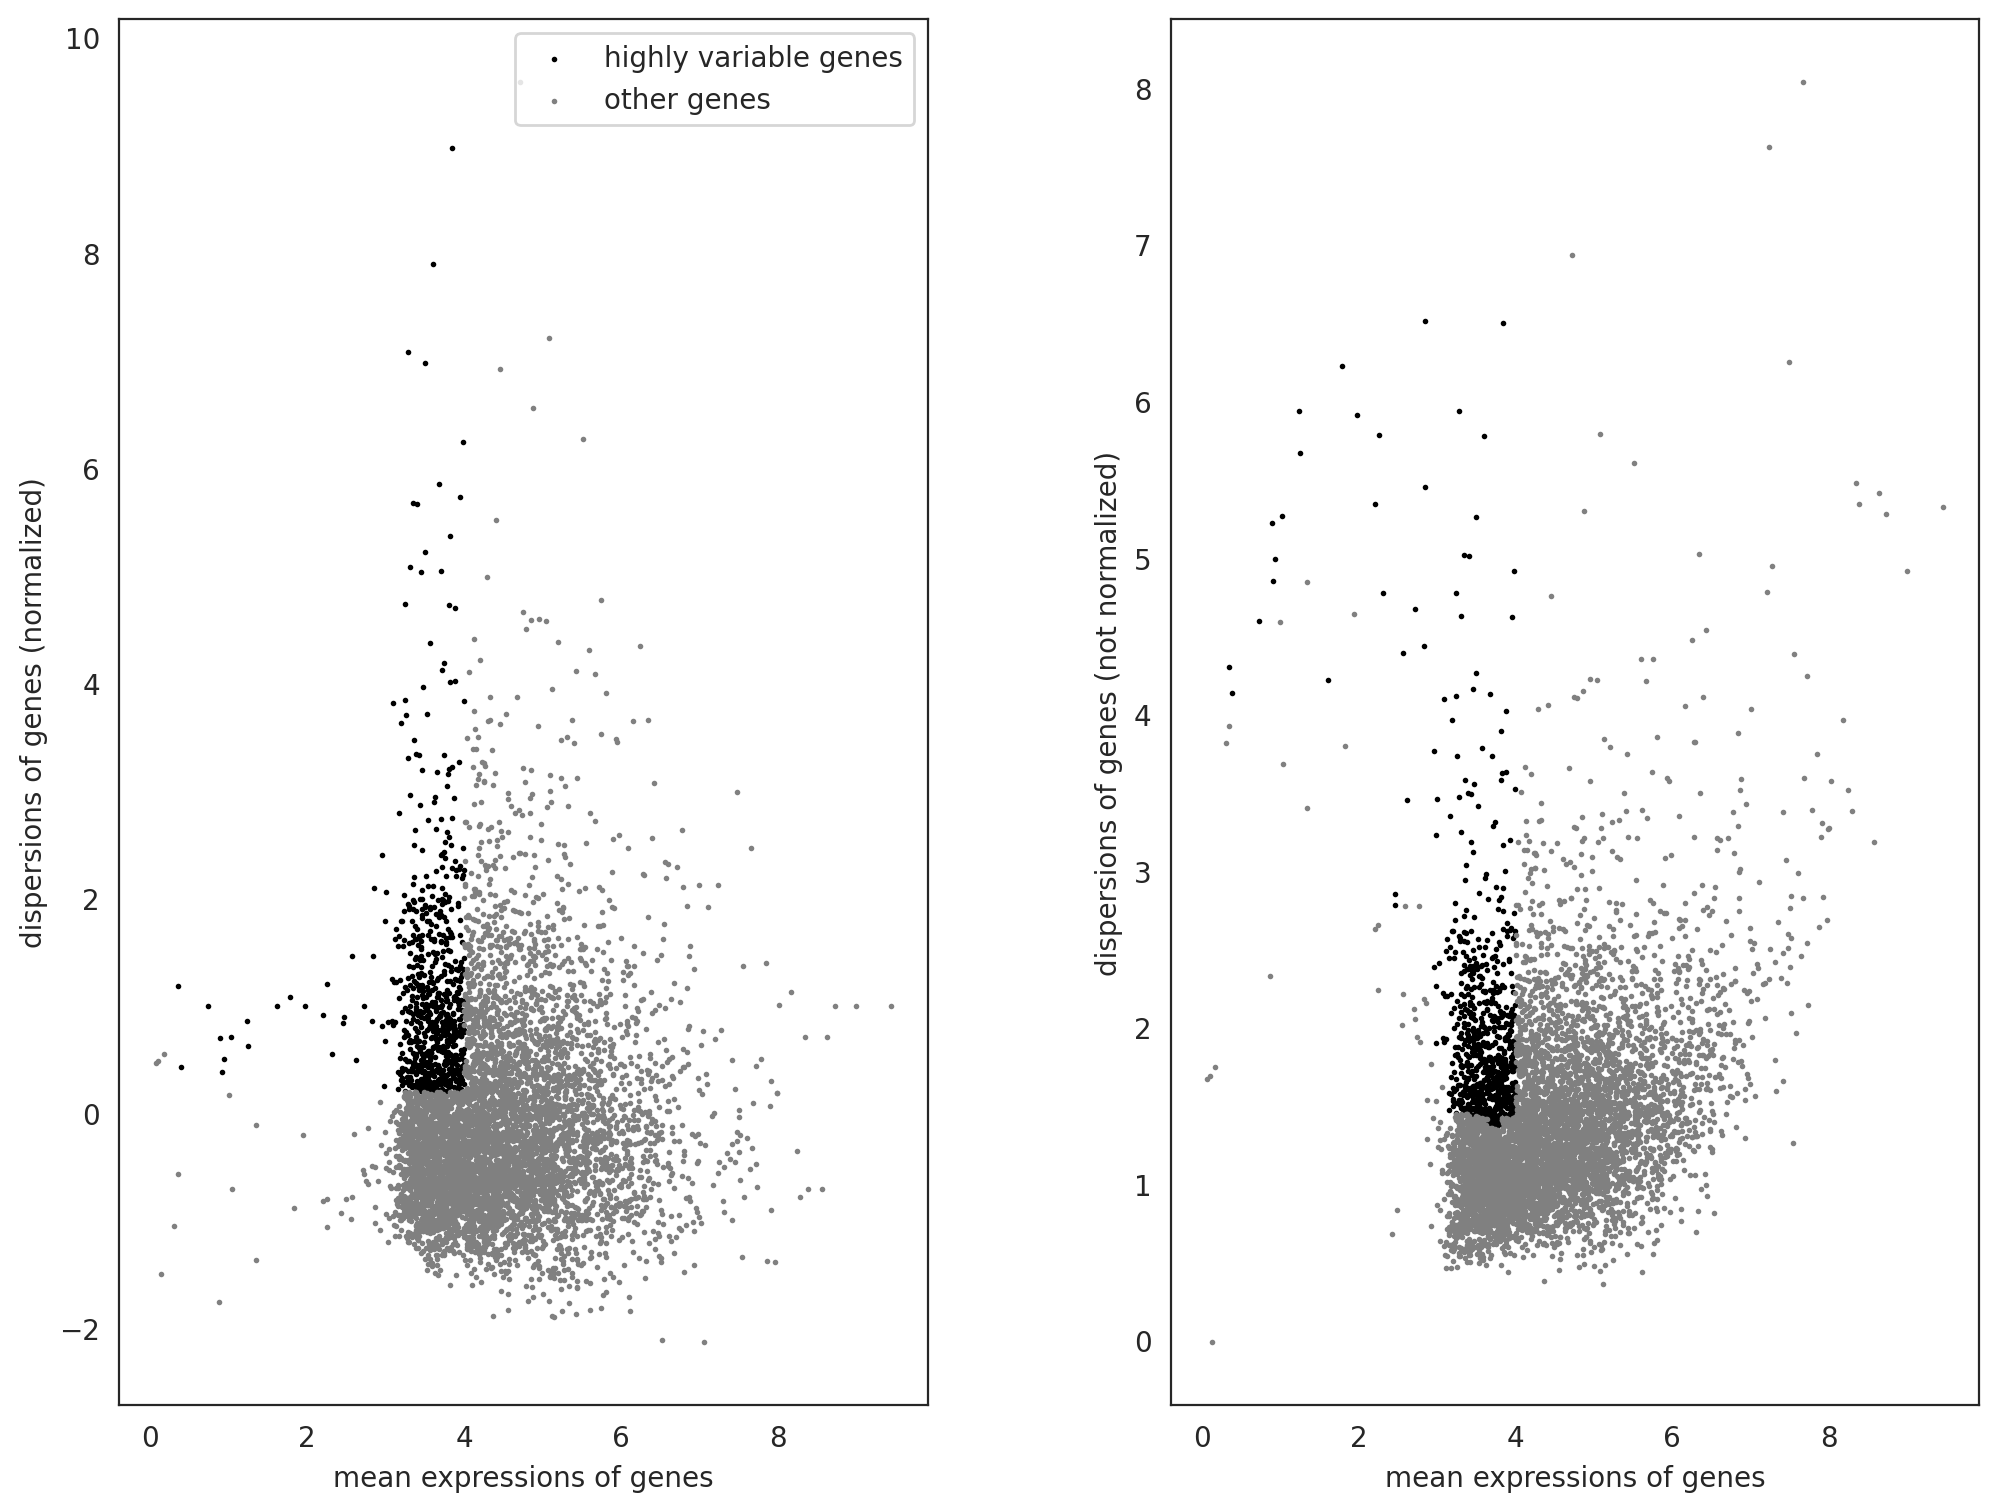

In [54]:
sc.pp.log1p(pseudobulk)
sc.pp.highly_variable_genes(pseudobulk, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(pseudobulk)
with warnings.catch_warnings():
    sc.tl.pca(pseudobulk, n_comps=100)
sc.pp.neighbors(pseudobulk)
sc.tl.umap(pseudobulk)
clusterResolutions = []
sc.tl.leiden(pseudobulk)
cc_genes = pd.read_csv(cellcycleGenePath, header = None)[0]
sc.tl.score_genes_cell_cycle(pseudobulk, s_genes=cc_genes[:43], g2m_genes=cc_genes[43:])

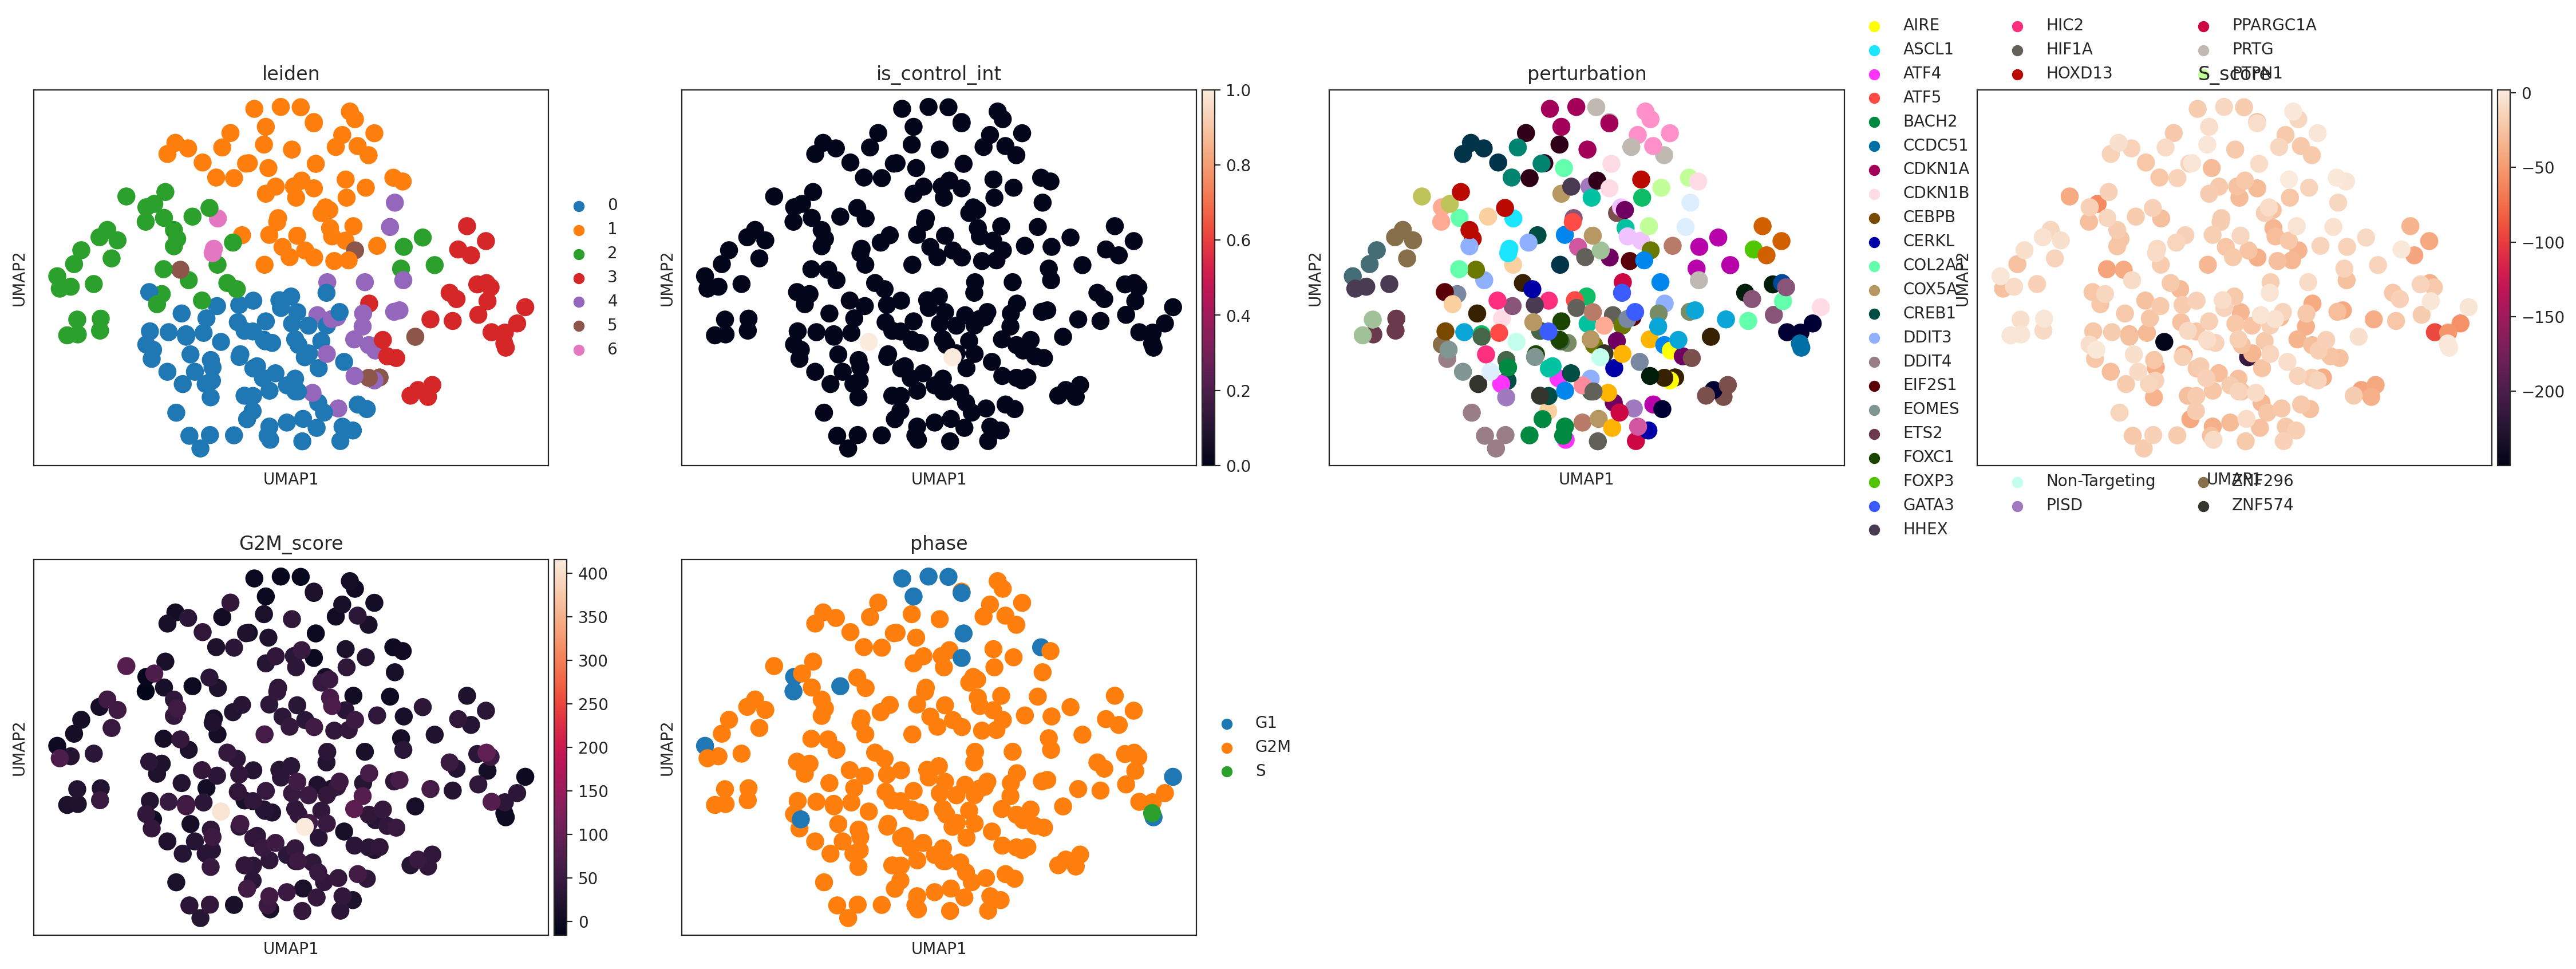

In [55]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(pseudobulk, color = [
    # "PTPRC",
    "leiden", 
    "is_control_int",
    "perturbation",
    'S_score',
    'G2M_score', 
    'phase', 
    # 'total_counts', 
    # 'log1p_total_counts',
    # 'pct_counts_in_top_50_genes', 
    # 'has_guide_annotations',
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
pseudobulk.obs["fake_cluster"]="all_one_cluster"
pseudobulk.obs.fake_cluster = pseudobulk.obs.fake_cluster.astype("category")
pseudobulk.uns["fake_cluster_colors"] = ['#1f77b4']

In [56]:
pseudobulk

AnnData object with n_obs × n_vars = 233 × 6651
    obs: 'is_control', 'is_control_int', 'perturbation', 'guideRNA', 'consistentW/Perturbation', 'logFC', 'spearmanCorr', ' pearsonCorr', 'DEG', 'MI', 'logFCMean', 'logFCNorm2', 'logFCMedian', 'TFOnlyDEG', 'TFOnlyMI', 'TFOnlylogFCMean', 'TFOnlylogFCNorm2', 'TFOnlylogFCMedian', 'leiden', 'S_score', 'G2M_score', 'phase', 'fake_cluster'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'perturbation_colors', 'phase_colors', 'fake_cluster_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Data reduction/QC already happened (see above)

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [57]:
perturbed_genes = set(list(pseudobulk.obs['perturbation'].unique())).difference(controls)
# perturbed_genes.remove(np.nan)
perturbed_and_measured_genes = perturbed_genes.intersection(pseudobulk.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(pseudobulk.var.index)
genes_keep = pseudobulk.var.index[pseudobulk.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
print("These genes were perturbed:")
print(perturbed_genes)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

These genes were perturbed:
{'SREBF1', 'PISD', 'ETS2', 'MTOR', 'ASCL1', 'CREB1', 'NPM1', 'TTC6', 'HIC2', 'ATF5', 'FOXC1', 'SPI1', 'CERKL', 'HHEX', 'CDKN1A', 'MAPK1', 'GATA3', 'HIF1A', 'CDKN1B', 'TIMM50', 'EOMES', 'MAP2K3', 'RPS18', 'DDIT4', 'IRF1', 'TMA7', 'BACH2', 'HSPA9', 'NRF1', 'TIPARP', 'MEIS2', 'PRTG', 'MAP2K6', 'COL2A1', 'CEBPB', 'HSPD1', 'TLE3', 'IGDCC3', 'ZNF574', 'AIRE', 'PTPN1', 'TBX21', 'SET', 'TFAP4', 'NEUROG2', 'EIF2S1', 'RANBP1', 'KLF1', 'CCDC51', 'COX5A', 'FOXP3', 'PPARGC1A', 'DDIT3', 'ZNF236', 'LHX4', 'UPF1', 'HOXD13', 'NEUROD1', 'ZNF296', 'HSF1', 'RORA', 'ATF4', 'RPL30'}
These genes were perturbed but not measured:
{'PPARGC1A', 'CERKL'}
This many variable genes will be kept and used by CO:
800


In [58]:
# final form, ready to save
pseudobulk.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
pseudobulk.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
pseudobulk = ingestion.describe_perturbation_effect(pseudobulk, "overexpression")

In [59]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")